**<center><h1>Exploratory Data Analysis of House Prices Using Llama 3.1-8B and Function Calling Integration</h1></center>**

In this notebook, we explore how Llama 3.1-8B with function calling assists in data analysis based on user questions. By interpreting queries and dynamically interacting with analytical functions, the model provides targeted insights for exploring house prices efficiently.

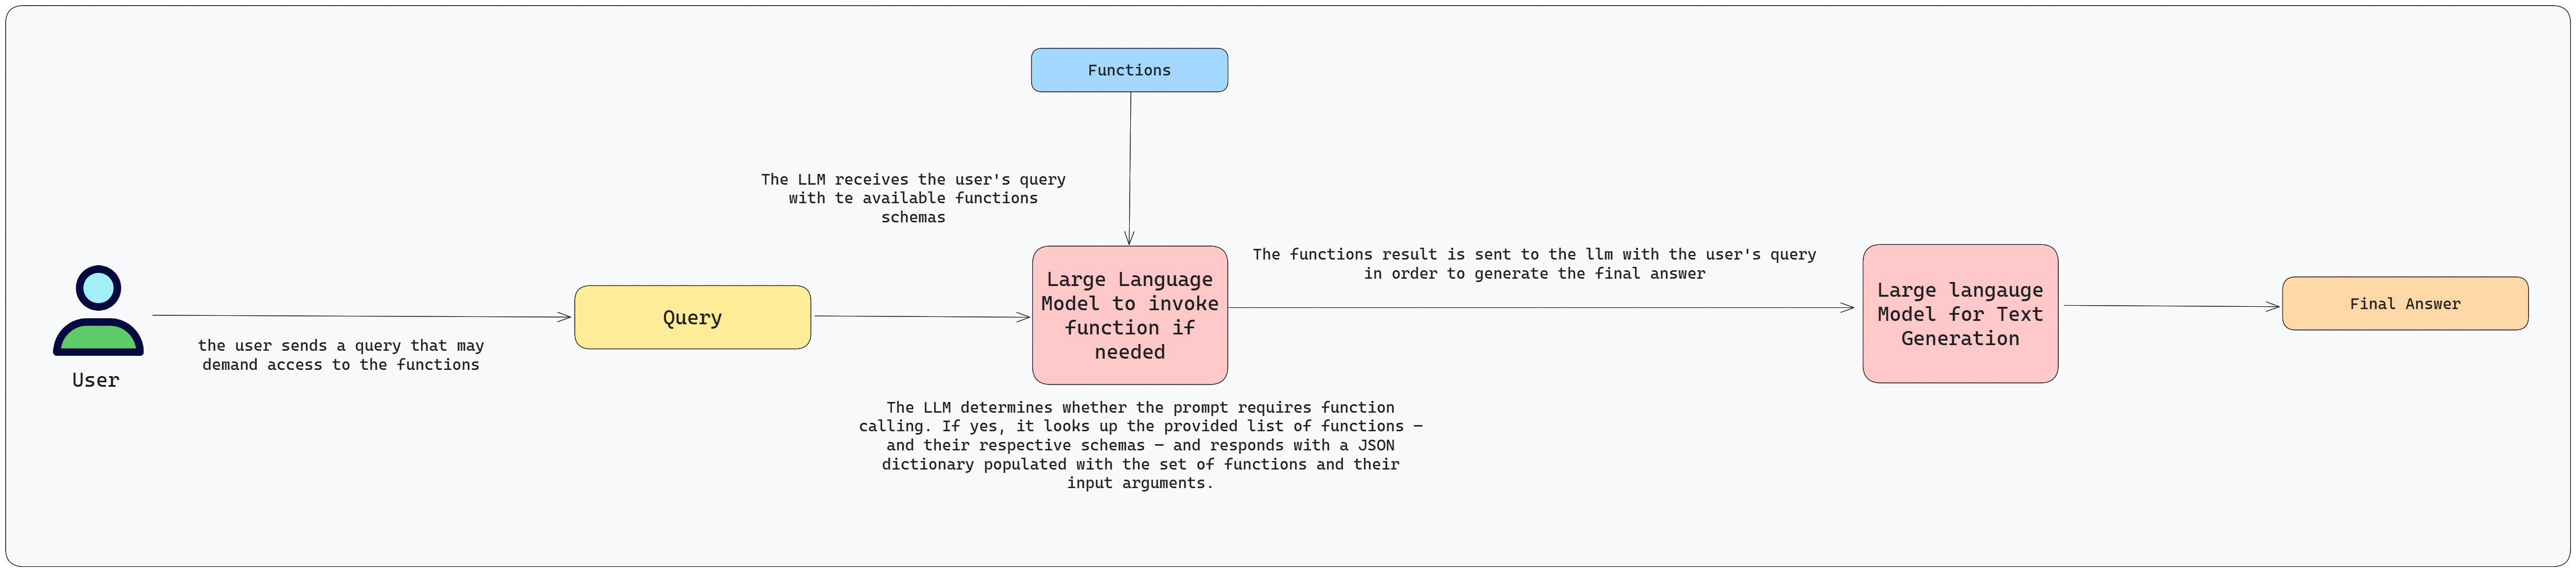

## **Table of Contents**

* [Step 1. Install Libraries](#h1)

* [Step 2. Load Llama-3.1-8B with Groq](#h2)

* [Step 3. Defining Tools](#h3)

* [Step 4. Testing Function Calling with LLM](#h4)

* [Step 5. Improving Generated Output](#h5)

## **Step 1. Install Libraries** <a class="anchor"  id="h1"></a>

In [1]:
%%capture
! pip install langchain
! pip install langchain_community
! pip install langchain-openai
! pip install langchain-google-genai

## **Step 2. Load Llama-3.1-8B with Groq** <a class="anchor"  id="h2"></a>

In [4]:
from langchain_openai import ChatOpenAI

llama3_1_8b = ChatOpenAI(api_key="**********************************", 
                    base_url="https://api.groq.com/openai/v1",
                    model="llama-3.1-8b-instant",#"llama3-8b-8192",
                   )

llama3_1_8b

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7c3372825b10>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7c3372827370>, root_client=<openai.OpenAI object at 0x7c3375cd7370>, root_async_client=<openai.AsyncOpenAI object at 0x7c3372825b70>, model_name='llama-3.1-8b-instant', model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='https://api.groq.com/openai/v1')

after loading the large language model, let's see if it works.

In [5]:
ai_msg = llama3_1_8b.invoke("What is the meaning of life")

print(ai_msg.content)

The question of the meaning of life is one of the most profound and enduring questions in human history. It has been debated and explored by philosophers, theologians, scientists, and thinkers across various disciplines and cultures.

There is no one definitive answer to this question, as the meaning of life can vary greatly depending on individual perspectives, values, and experiences. However, here are some possible interpretations:

1. **Biological perspective**: From a biological standpoint, the meaning of life can be seen as survival and reproduction. Living organisms strive to survive, reproduce, and ensure the continuation of their genetic lineage.
2. **Personal fulfillment**: Many people believe that the meaning of life is to find personal fulfillment, happiness, and purpose. This can be achieved through pursuing one's passions, building meaningful relationships, and contributing to the greater good.
3. **Spiritual perspective**: In many spiritual traditions, the meaning of lif

## **Step 3. Defining Tools** <a class="anchor"  id="h3"></a>

Now let's define the functions that we are going to use for function calling with llm, here we are going to define different functions to obtain analysis of different aspects of the training dataset from [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview) competition.

In [6]:
from langchain_core.tools import tool
from typing import Dict, List, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


# Sample DataFrame for demonstration
def create_sample_data():
    df_house_prices = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
    return pd.DataFrame(df_house_prices)



def load_dataframe(file_path: str) -> pd.DataFrame:
    """Helper function to load DataFrame from CSV"""
    return pd.read_csv(file_path)


@tool
def get_basic_info() -> Dict:
    """Get basic information about the dataset.
    
    Args:
        file_path: Path to the CSV file containing house prices data
    
    Returns:
        Dictionary containing basic dataset information
    """
    df = load_dataframe("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    return {
        'Total_Rows': int(len(df)),
        'Total_Columns': int(len(df.columns)),
        'Numeric_Features': int(len(numeric_cols)),
        'Categorical_Features': int(len(categorical_cols)),
        'Missing_Values': int(df.isnull().sum().sum()),
        'Memory_Usage_KB': float(df.memory_usage().sum() / 1024)
    }

@tool
def analyze_missing_values() -> Dict[str, float]:
    """Analyze missing values in the dataset and create visualization.
    
    Args:
        file_path: Path to the CSV file containing house prices data
    
    Returns:
        Dictionary with feature names as keys and missing percentage as values
    """
    df = load_dataframe("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
    missing = (df.isnull().sum() / len(df)) * 100
    missing = missing[missing > 0].sort_values(ascending=False)
    
    if len(missing) > 0:
        plt.figure(figsize=(10, 6))
        missing.plot(kind='bar')
        plt.title('Percentage of Missing Values by Feature')
        plt.xlabel('Features')
        plt.ylabel('Percentage Missing')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    return {k: float(v) for k, v in missing.to_dict().items()}

@tool
def plot_correlation_analysis(target: str = 'SalePrice') -> Dict[str, float]:
    """Analyze and visualize correlations with target variable.
    
    Args:
        file_path: Path to the CSV file containing house prices data
        target: Target variable name (default: 'SalePrice')
    
    Returns:
        Dictionary with feature names as keys and correlation values as values
    """
    df = load_dataframe("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    correlations = df[numeric_cols].corr()[target].sort_values(ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[numeric_cols].corr(), 
                cmap='coolwarm', 
                center=0,
                annot=False)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    return {k: float(v) for k, v in correlations.to_dict().items()}

@tool
def analyze_target_distribution(target: str = 'SalePrice') -> Dict[str, float]:
    """Analyze distribution of target variable.
    
    Args:
        file_path: Path to the CSV file containing house prices data
        target: Target variable name (default: 'SalePrice')
    
    Returns:
        Dictionary containing distribution statistics
    """
    df = load_dataframe("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[target], kde=True)
    plt.title(f'{target} Distribution')
    
    plt.subplot(1, 2, 2)
    stats.probplot(df[target], dist="norm", plot=plt)
    plt.title(f'{target} Q-Q Plot')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'Skewness': float(stats.skew(df[target])),
        'Kurtosis': float(stats.kurtosis(df[target])),
        'Mean': float(df[target].mean()),
        'Median': float(df[target].median()),
        'Std': float(df[target].std())
    }

@tool
def analyze_categorical_features(target: str = 'SalePrice') -> Dict[str, dict]:
    """Analyze categorical variables relationship with target.
    
    Args:
        file_path: Path to the CSV file containing house prices data
        target: Target variable name (default: 'SalePrice')
    
    Returns:
        Nested dictionary containing analysis results for each categorical feature
    """
    df = load_dataframe("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
    categorical_cols = df.select_dtypes(include=['object']).columns
    results = {}
    
    for col in categorical_cols:
        if len(df[col].unique()) < 30:
            mean_target = df.groupby(col)[target].mean().sort_values(ascending=False)
            count_cats = df[col].value_counts()
            
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            sns.boxplot(x=col, y=target, data=df)
            plt.xticks(rotation=45)
            plt.title(f'{target} by {col}')
            
            plt.subplot(1, 2, 2)
            count_cats.plot(kind='bar')
            plt.title(f'{col} Value Counts')
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()
            
            results[col] = {
                'unique_values': int(len(df[col].unique())),
                'mean_target_by_category': {k: float(v) for k, v in mean_target.to_dict().items()},
                'category_counts': {k: int(v) for k, v in count_cats.to_dict().items()}
            }
    
    return results

@tool
def analyze_numeric_features(target: str = 'SalePrice') -> Dict[str, dict]:
    """Analyze relationships between numeric features and target.
    
    Args:
        file_path: Path to the CSV file containing house prices data
        target: Target variable name (default: 'SalePrice')
    
    Returns:
        Dictionary containing analysis results for each numeric feature
    """
    df = load_dataframe("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    results = {}
    
    for col in numeric_cols:
        if col != target:
            correlation = float(df[col].corr(df[target]))
            
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            sns.scatterplot(x=col, y=target, data=df)
            plt.title(f'{target} vs {col}\nCorrelation: {correlation:.2f}')
            
            plt.subplot(1, 2, 2)
            sns.histplot(df[col], kde=True)
            plt.title(f'{col} Distribution')
            
            plt.tight_layout()
            plt.show()
            
            results[col] = {
                'correlation': float(correlation),
                'skewness': float(stats.skew(df[col].dropna())),
                'missing_values': int(df[col].isnull().sum())
            }
    
    return results

@tool
def check_skewness() -> Dict[str, float]:
    """Check skewness of numeric features.
    
    Args:
        file_path: Path to the CSV file containing house prices data
    
    Returns:
        Dictionary with feature names as keys and skewness values as values
    """
    df = load_dataframe("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    skewness = df[numeric_cols].apply(lambda x: float(stats.skew(x.dropna())))
    return {k: float(v) for k, v in skewness.sort_values(ascending=False).to_dict().items()}

@tool
def get_top_correlated_features(target: str = 'SalePrice', top_n: int = 10) -> Dict[str, float]:
    """Get the top correlated features with the target variable.
    
    Args:
        file_path: Path to the CSV file containing house prices data
        target: Target variable name (default: 'SalePrice')
        top_n: Number of top correlated features to return (default: 10)
    
    Returns:
        Dictionary with feature names as keys and correlation values as values
    """
    df = load_dataframe("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    correlations = df[numeric_cols].corr()[target].sort_values(ascending=False)
    top_correlations = correlations[1:top_n+1]  # Exclude target variable itself
    return {k: float(v) for k, v in top_correlations.to_dict().items()}


tools = [get_basic_info, 
         analyze_missing_values, 
         plot_correlation_analysis,
         analyze_target_distribution,
         analyze_categorical_features,
         analyze_numeric_features,
         check_skewness,
         get_top_correlated_features]

In [7]:
llama3_1_with_tools = llama3_1_8b.bind_tools(tools) # tool_choice = 'any', 'actual_tool_name', 

ai_msg = llama3_1_with_tools.invoke("i want to see the top correlated features with salesprice")

ai_msg.tool_calls

[{'name': 'get_top_correlated_features',
  'args': {'file_path': 'housing_data.csv',
   'target': 'SalePrice',
   'top_n': 10},
  'id': 'call_vgpe',
  'type': 'tool_call'}]

## **Step 4. Testing Function Calling with LLM** <a class="anchor"  id="h4"></a>

In [8]:
from langchain_core.messages import HumanMessage, ToolMessage


#query = "i want to check the skewness of the numerical features"
def answer_question_with_function_calling(user_query):
    messages = [HumanMessage(user_query)]
    ai_msg = llama3_1_with_tools.invoke(user_query)
    messages.append(ai_msg)

    for tool_call in ai_msg.tool_calls:
        selected_tool = {"get_basic_info": get_basic_info, 
                         "analyze_missing_values":analyze_missing_values,
                         "plot_correlation_analysis": plot_correlation_analysis,
                         "analyze_target_distribution":analyze_target_distribution,
                         "analyze_categorical_features": analyze_categorical_features,
                         "analyze_numeric_features": analyze_numeric_features, 
                         "check_skewness": check_skewness, 
                         "get_top_correlated_features": get_top_correlated_features}[tool_call["name"].lower()]
        tool_output = selected_tool.invoke(tool_call["args"])
        print(tool_output)
        messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))
    print(messages)
    final_response = llama3_1_8b.invoke(messages)
    print("explanation:")
    print(final_response.content)

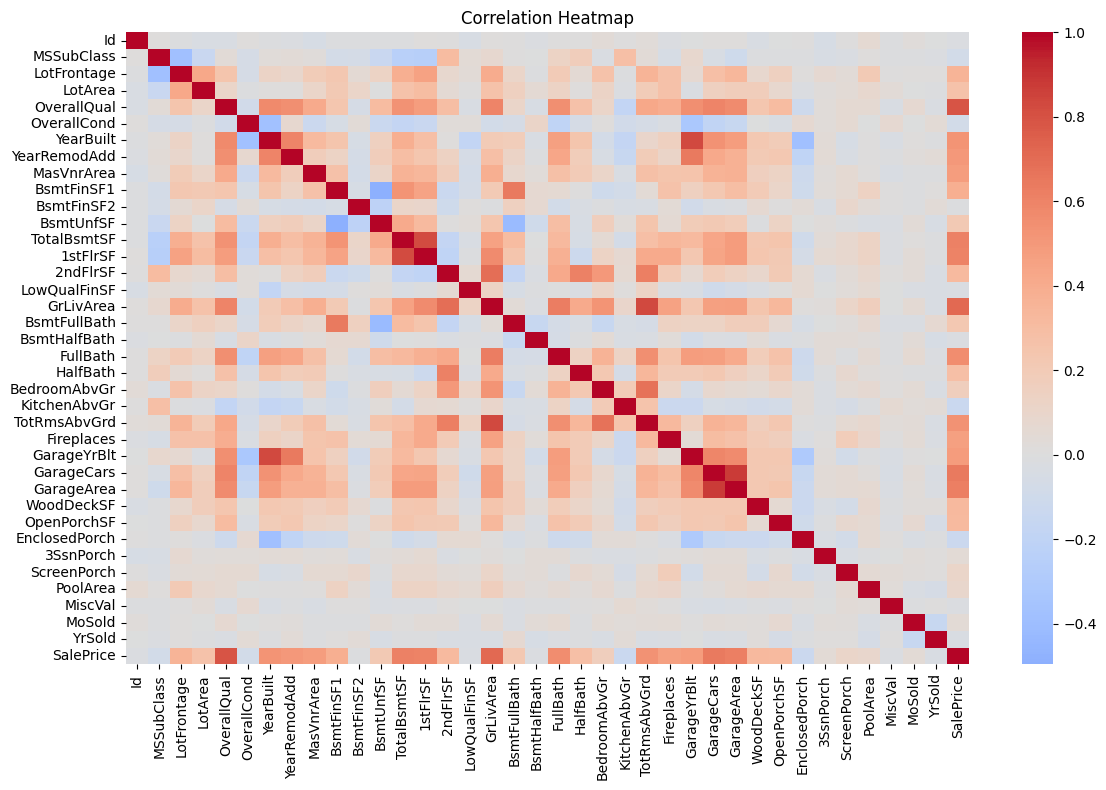

{'SalePrice': 1.0, 'OverallQual': 0.7909816005838053, 'GrLivArea': 0.7086244776126515, 'GarageCars': 0.6404091972583519, 'GarageArea': 0.6234314389183622, 'TotalBsmtSF': 0.6135805515591943, '1stFlrSF': 0.6058521846919153, 'FullBath': 0.5606637627484453, 'TotRmsAbvGrd': 0.5337231555820284, 'YearBuilt': 0.5228973328794967, 'YearRemodAdd': 0.5071009671113866, 'GarageYrBlt': 0.4863616774878596, 'MasVnrArea': 0.47749304709571444, 'Fireplaces': 0.46692883675152763, 'BsmtFinSF1': 0.3864198062421535, 'LotFrontage': 0.35179909657067737, 'WoodDeckSF': 0.32441344456812926, '2ndFlrSF': 0.31933380283206736, 'OpenPorchSF': 0.31585622711605504, 'HalfBath': 0.28410767559478256, 'LotArea': 0.2638433538714051, 'BsmtFullBath': 0.22712223313149427, 'BsmtUnfSF': 0.21447910554696928, 'BedroomAbvGr': 0.16821315430073963, 'ScreenPorch': 0.11144657114291112, 'PoolArea': 0.09240354949187318, 'MoSold': 0.046432245223819446, '3SsnPorch': 0.04458366533574838, 'BsmtFinSF2': -0.011378121450215146, 'BsmtHalfBath': -0

In [9]:
answer_question_with_function_calling("i want to see the correlation between the variables")

In [10]:
answer_question_with_function_calling("i want to see the top correlated features with salesprice")

{'OverallQual': 0.7909816005838053, 'GrLivArea': 0.7086244776126515, 'GarageCars': 0.6404091972583519, 'GarageArea': 0.6234314389183622, 'TotalBsmtSF': 0.6135805515591943, '1stFlrSF': 0.6058521846919153, 'FullBath': 0.5606637627484453, 'TotRmsAbvGrd': 0.5337231555820284, 'YearBuilt': 0.5228973328794967, 'YearRemodAdd': 0.5071009671113866}
[HumanMessage(content='i want to see the top correlated features with salesprice', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_76zd', 'function': {'arguments': '{"file_path": "/home/user/house_prices.csv", "target": "SalePrice", "top_n": 10}', 'name': 'get_top_correlated_features'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 1326, 'total_tokens': 1362, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'queue_time': 0.002819593000000009, 'prompt_time': 0.27190047, 'completion_time': 0.048, 'tota

In [11]:
answer_question_with_function_calling("Display basic information about the dataset")

{'Total_Rows': 1460, 'Total_Columns': 81, 'Numeric_Features': 38, 'Categorical_Features': 43, 'Missing_Values': 7829, 'Memory_Usage_KB': 924.03125}
[HumanMessage(content='Display basic information about the dataset', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wnex', 'function': {'arguments': '{"file_path": "/path/to/house_prices_data.csv"}', 'name': 'get_basic_info'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 1321, 'total_tokens': 1343, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'queue_time': 0.002380710000000008, 'prompt_time': 0.275793793, 'completion_time': 0.029333333, 'total_time': 0.305127126}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5e5c84ba-0dbe-4804-9106-bd43faa02dc8-0', tool_calls=[{'name': 'get_basic_info', 'args': 

In [12]:
answer_question_with_function_calling("i want to check the skewness of the numerical features")

[HumanMessage(content='i want to check the skewness of the numerical features', additional_kwargs={}, response_metadata={}), AIMessage(content='<function=check_skewness>{"file_path": "house_prices_data.csv"}', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 1326, 'total_tokens': 1344, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'queue_time': 0.002579139000000008, 'prompt_time': 0.271352509, 'completion_time': 0.024, 'total_time': 0.295352509}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'stop', 'logprobs': None}, id='run-fa4267b7-71c4-41da-a26a-29e37b77cd5c-0', usage_metadata={'input_tokens': 1326, 'output_tokens': 18, 'total_tokens': 1344, 'input_token_details': {}, 'output_token_details': {}})]
explanation:
>

Here's an example of how you can check the skewness of the numerical features using Python's `pandas` and `numpy` libraries.

```python
# Im

In [13]:
answer_question_with_function_calling("i want to check the skewness of the numerical features")

{'MiscVal': 24.4516396173223, 'PoolArea': 14.813134660429398, 'LotArea': 12.195142125084478, '3SsnPorch': 10.293752357165413, 'LowQualFinSF': 9.002080417658552, 'KitchenAbvGr': 4.483784093860484, 'BsmtFinSF2': 4.250888017057445, 'ScreenPorch': 4.1179773827954875, 'BsmtHalfBath': 4.0991856695420035, 'EnclosedPorch': 3.086696471376678, 'MasVnrArea': 2.6663261001607435, 'OpenPorchSF': 2.361911928568972, 'LotFrontage': 2.160865994705543, 'SalePrice': 1.880940746034036, 'BsmtFinSF1': 1.6837708962341815, 'WoodDeckSF': 1.5397916998042025, 'TotalBsmtSF': 1.522688086978629, 'MSSubClass': 1.4062101115313512, '1stFlrSF': 1.3753417421837937, 'GrLivArea': 1.365155954773434, 'BsmtUnfSF': 0.9193227015582005, '2ndFlrSF': 0.8121942731961613, 'OverallCond': 0.6923552135520978, 'TotRmsAbvGrd': 0.6756457673102017, 'HalfBath': 0.6752028347742616, 'Fireplaces': 0.6488976310170327, 'BsmtFullBath': 0.5954540376067279, 'OverallQual': 0.2167209765258641, 'MoSold': 0.2118350601903434, 'BedroomAbvGr': 0.211572441

## **Step 5. Improving Generated Output** <a class="anchor"  id="h5"></a>

After testing the technique in the cells above, I observed that while the LLM correctly identifies the appropriate function to execute, it struggles to generate an accurate response, and in many times it generates a python code that can be used to extract data based on the provided question which is useless in our case. To address this, we will refine the prompt to guide the model in producing a more precise and relevant answer.

First let's define the prompt template that we are going to use.

In [14]:
from langchain import PromptTemplate

template = """You are an expert in data analysis. You are provided with the user's question and informations from a dataset(House Prices dataset) that already answer the user's question. 
- Analyze the informations and generate an insightful paragraph based on the information from the dataset. 
- if the provided informations contain numerical values, please add them to the paragraph as an explanation.

Dataset Information: {dataset_info}

User's Question: {query}

Your Answer: """


prompt_template = PromptTemplate(
    input_variables=["dataset_info", "query"],
    template=template
)

In [15]:
def answer_question_with_function_calling_enhanced(user_query):
    messages = [HumanMessage(user_query)]
    ai_msg = llama3_1_with_tools.invoke(user_query)
    messages.append(ai_msg)

    for tool_call in ai_msg.tool_calls:
        selected_tool = {"get_basic_info": get_basic_info, 
                         "analyze_missing_values":analyze_missing_values,
                         "plot_correlation_analysis": plot_correlation_analysis,
                         "analyze_target_distribution":analyze_target_distribution,
                         "analyze_categorical_features": analyze_categorical_features,
                         "analyze_numeric_features": analyze_numeric_features, 
                         "check_skewness": check_skewness, 
                         "get_top_correlated_features": get_top_correlated_features}[tool_call["name"].lower()]
        tool_output = selected_tool.invoke(tool_call["args"])
        print(tool_output)
        messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))
    final_response = llama3_1_8b(
        prompt_template.format(
            query=user_query,
            dataset_info=tool_output
        )
    )
    print("\n")
    print("explanation:")
    print(final_response.content)

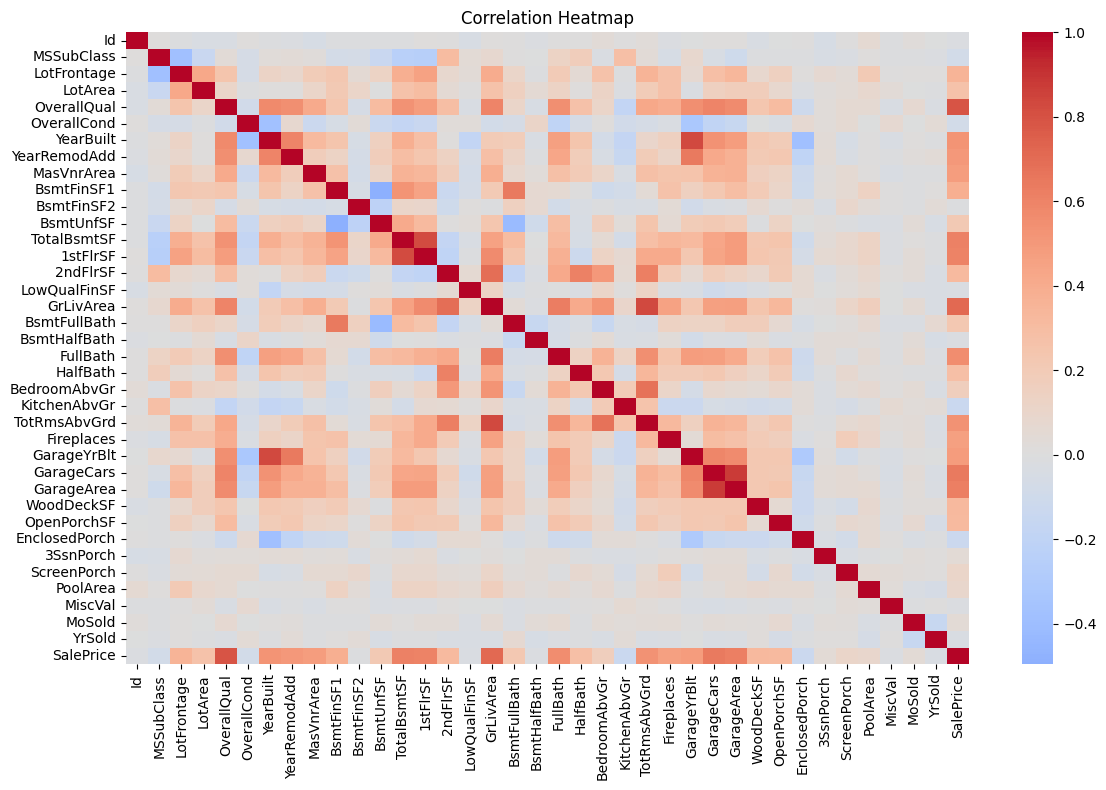

{'SalePrice': 1.0, 'OverallQual': 0.7909816005838053, 'GrLivArea': 0.7086244776126515, 'GarageCars': 0.6404091972583519, 'GarageArea': 0.6234314389183622, 'TotalBsmtSF': 0.6135805515591943, '1stFlrSF': 0.6058521846919153, 'FullBath': 0.5606637627484453, 'TotRmsAbvGrd': 0.5337231555820284, 'YearBuilt': 0.5228973328794967, 'YearRemodAdd': 0.5071009671113866, 'GarageYrBlt': 0.4863616774878596, 'MasVnrArea': 0.47749304709571444, 'Fireplaces': 0.46692883675152763, 'BsmtFinSF1': 0.3864198062421535, 'LotFrontage': 0.35179909657067737, 'WoodDeckSF': 0.32441344456812926, '2ndFlrSF': 0.31933380283206736, 'OpenPorchSF': 0.31585622711605504, 'HalfBath': 0.28410767559478256, 'LotArea': 0.2638433538714051, 'BsmtFullBath': 0.22712223313149427, 'BsmtUnfSF': 0.21447910554696928, 'BedroomAbvGr': 0.16821315430073963, 'ScreenPorch': 0.11144657114291112, 'PoolArea': 0.09240354949187318, 'MoSold': 0.046432245223819446, '3SsnPorch': 0.04458366533574838, 'BsmtFinSF2': -0.011378121450215146, 'BsmtHalfBath': -0

In [16]:
answer_question_with_function_calling_enhanced("i want to see the correlation between the variables")

In [17]:
answer_question_with_function_calling_enhanced("i want to see the top correlated features with salesprice")

{'OverallQual': 0.7909816005838053, 'GrLivArea': 0.7086244776126515, 'GarageCars': 0.6404091972583519, 'GarageArea': 0.6234314389183622, 'TotalBsmtSF': 0.6135805515591943, '1stFlrSF': 0.6058521846919153, 'FullBath': 0.5606637627484453, 'TotRmsAbvGrd': 0.5337231555820284, 'YearBuilt': 0.5228973328794967, 'YearRemodAdd': 0.5071009671113866}


explanation:
Based on the provided dataset information, we can see that the top correlated features with SalesPrice are OverallQual, GrLivArea, GarageCars, and GarageArea. 

The OverallQual feature, with a correlation coefficient of approximately 79%, suggests that the overall quality of a house has a significant and strong positive correlation with the SalesPrice. This means that houses with higher overall quality tend to have higher sales prices.

The GrLivArea feature, with a correlation coefficient of approximately 71%, also shows a strong positive correlation with SalesPrice, indicating that the living area of a house is a significant factor in

In [18]:
answer_question_with_function_calling_enhanced("Display basic information about the dataset")

{'Total_Rows': 1460, 'Total_Columns': 81, 'Numeric_Features': 38, 'Categorical_Features': 43, 'Missing_Values': 7829, 'Memory_Usage_KB': 924.03125}


explanation:
Based on the provided dataset information, I can generate an insightful paragraph that addresses the user's question.

The House Prices dataset consists of a substantial amount of data, with a total of 1460 rows and 81 features across 38 numeric and 43 categorical attributes. Despite its size, the dataset contains a notable amount of missing values, totaling 7829 records. This could potentially impact the accuracy of analysis and modeling results. Notably, the dataset's memory usage stands at approximately 924 KB, which suggests that it can be processed efficiently even on systems with limited memory resources. Overall, this dataset offers a rich source of information for analysis and modeling, but careful handling of the missing values is essential to unlock its full potential.


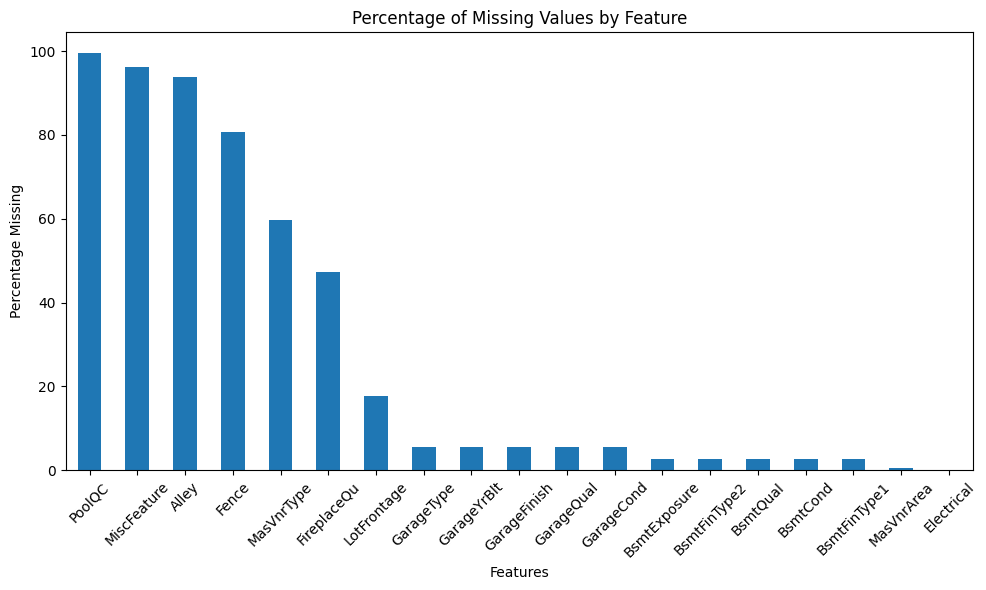

{'PoolQC': 99.52054794520548, 'MiscFeature': 96.30136986301369, 'Alley': 93.76712328767123, 'Fence': 80.75342465753424, 'MasVnrType': 59.726027397260275, 'FireplaceQu': 47.26027397260274, 'LotFrontage': 17.73972602739726, 'GarageType': 5.5479452054794525, 'GarageYrBlt': 5.5479452054794525, 'GarageFinish': 5.5479452054794525, 'GarageQual': 5.5479452054794525, 'GarageCond': 5.5479452054794525, 'BsmtExposure': 2.6027397260273974, 'BsmtFinType2': 2.6027397260273974, 'BsmtQual': 2.5342465753424657, 'BsmtCond': 2.5342465753424657, 'BsmtFinType1': 2.5342465753424657, 'MasVnrArea': 0.547945205479452, 'Electrical': 0.0684931506849315}


explanation:
Based on the provided dataset information, it seems there are no missing values to report since all values are associated with numerical values and names for categories. However, to provide a more detailed explanation, it's worth noting that the dataset is densely populated with values across various attributes. 

Notably, the dataset contains infor

In [19]:
answer_question_with_function_calling_enhanced("Are there any missing values in the dataset?")

In [20]:
answer_question_with_function_calling_enhanced("i want to check the skewness of the numerical features")

{'MiscVal': 24.4516396173223, 'PoolArea': 14.813134660429398, 'LotArea': 12.195142125084478, '3SsnPorch': 10.293752357165413, 'LowQualFinSF': 9.002080417658552, 'KitchenAbvGr': 4.483784093860484, 'BsmtFinSF2': 4.250888017057445, 'ScreenPorch': 4.1179773827954875, 'BsmtHalfBath': 4.0991856695420035, 'EnclosedPorch': 3.086696471376678, 'MasVnrArea': 2.6663261001607435, 'OpenPorchSF': 2.361911928568972, 'LotFrontage': 2.160865994705543, 'SalePrice': 1.880940746034036, 'BsmtFinSF1': 1.6837708962341815, 'WoodDeckSF': 1.5397916998042025, 'TotalBsmtSF': 1.522688086978629, 'MSSubClass': 1.4062101115313512, '1stFlrSF': 1.3753417421837937, 'GrLivArea': 1.365155954773434, 'BsmtUnfSF': 0.9193227015582005, '2ndFlrSF': 0.8121942731961613, 'OverallCond': 0.6923552135520978, 'TotRmsAbvGrd': 0.6756457673102017, 'HalfBath': 0.6752028347742616, 'Fireplaces': 0.6488976310170327, 'BsmtFullBath': 0.5954540376067279, 'OverallQual': 0.2167209765258641, 'MoSold': 0.2118350601903434, 'BedroomAbvGr': 0.211572441

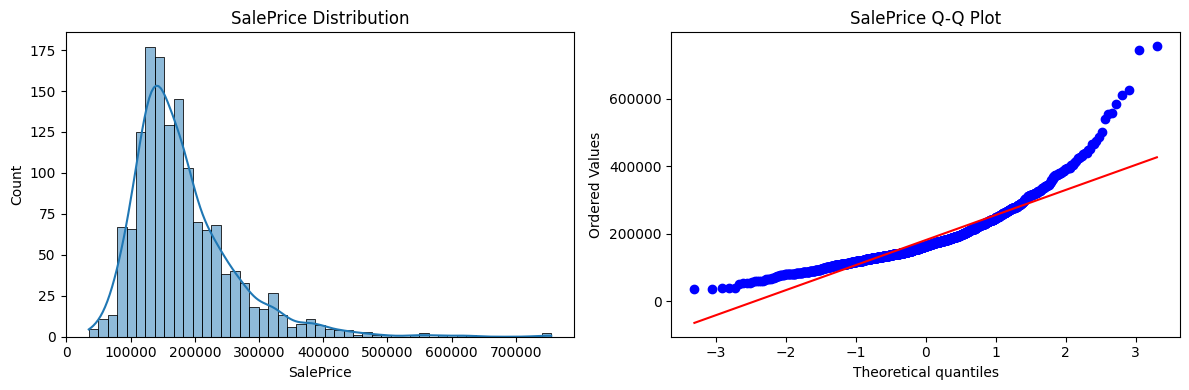

{'Skewness': 1.880940746034036, 'Kurtosis': 6.509812011089439, 'Mean': 180921.19589041095, 'Median': 163000.0, 'Std': 79442.50288288662}


explanation:
Based on the provided dataset information, it appears that the target variable, which represents house prices, exhibits a skewed distribution. The skewness value of 1.88 indicates a significant rightward skew, suggesting that there are more houses priced lower than the average house price, while a smaller number of houses are priced significantly higher. This is further supported by the kurtosis value of 6.51, which indicates that the distribution is also leptokurtic, meaning it has a higher peak and fatter tails than a normal distribution.

Additionally, the mean house price of $180,921 is higher than the median of $163,000, which suggests that the distribution is heavily influenced by a few high-priced houses. This is reflected in the standard deviation of $79,442, which is relatively high compared to the mean. Overall, these statisti

In [21]:
answer_question_with_function_calling_enhanced("I want to have an idea about the distribution of target variable")

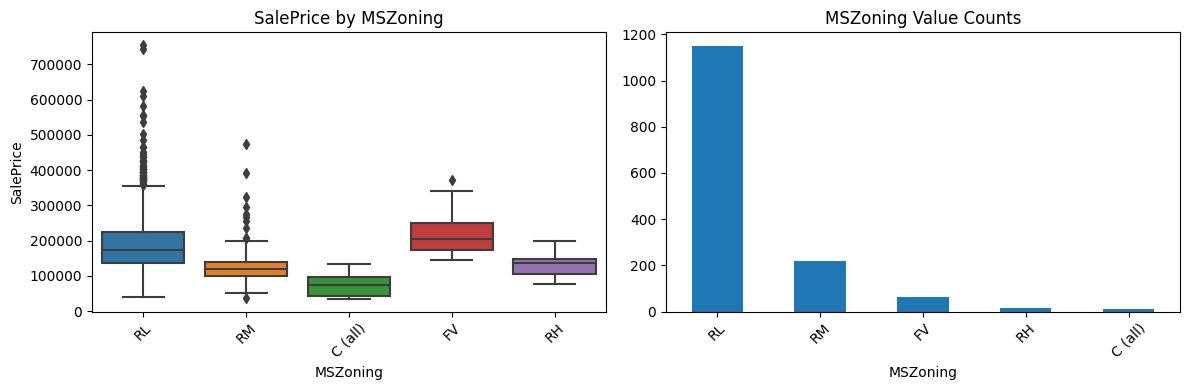

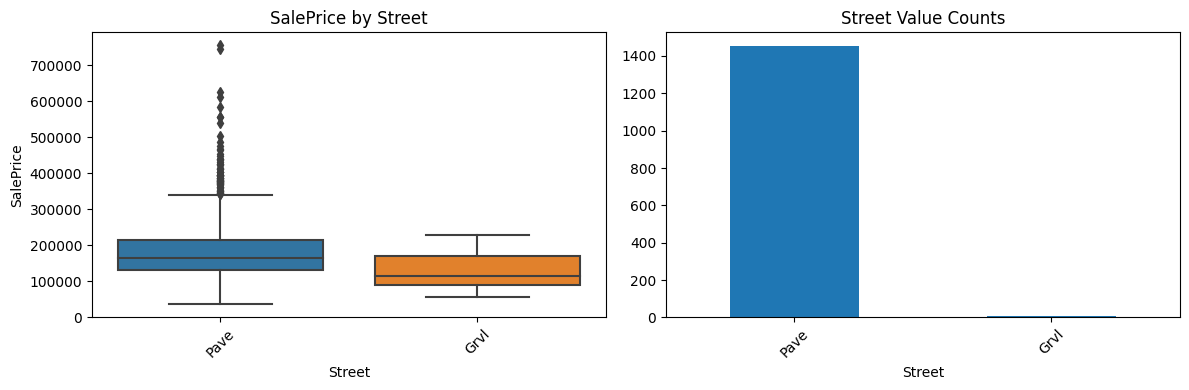

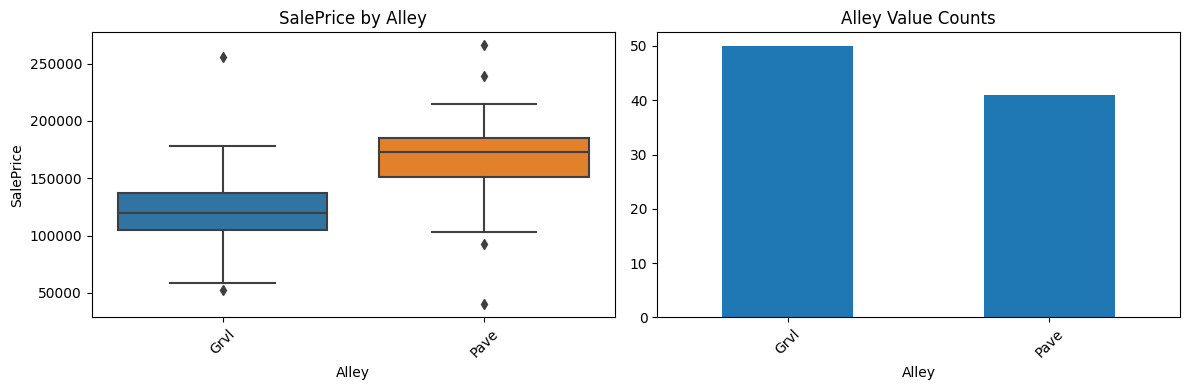

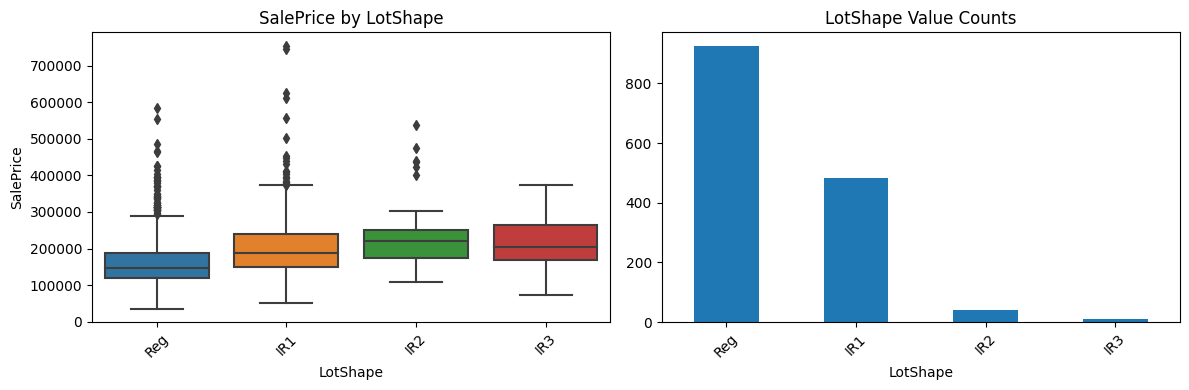

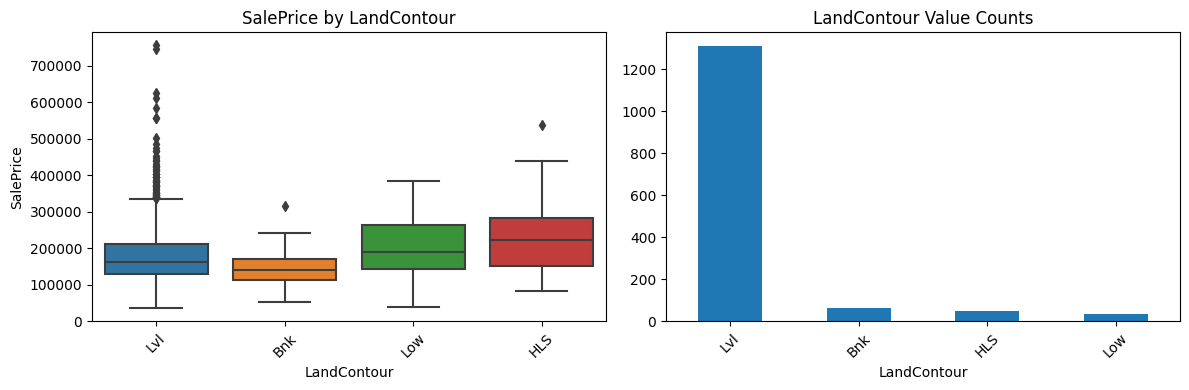

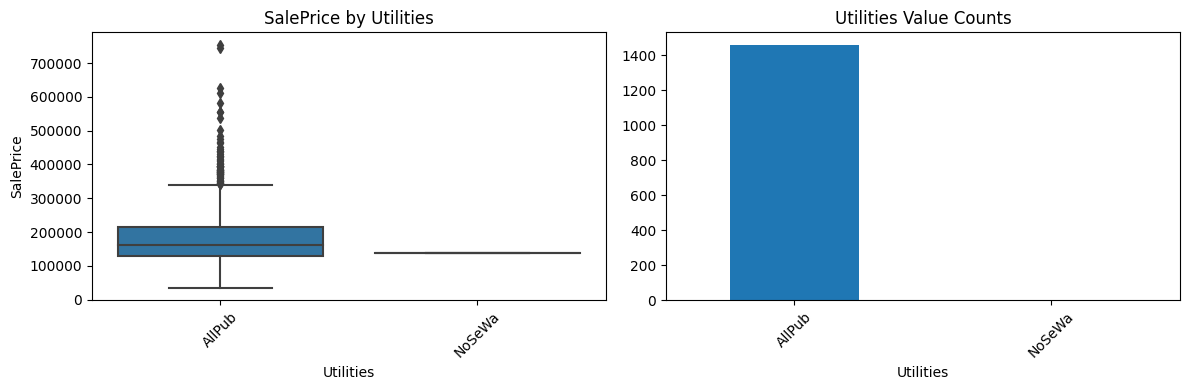

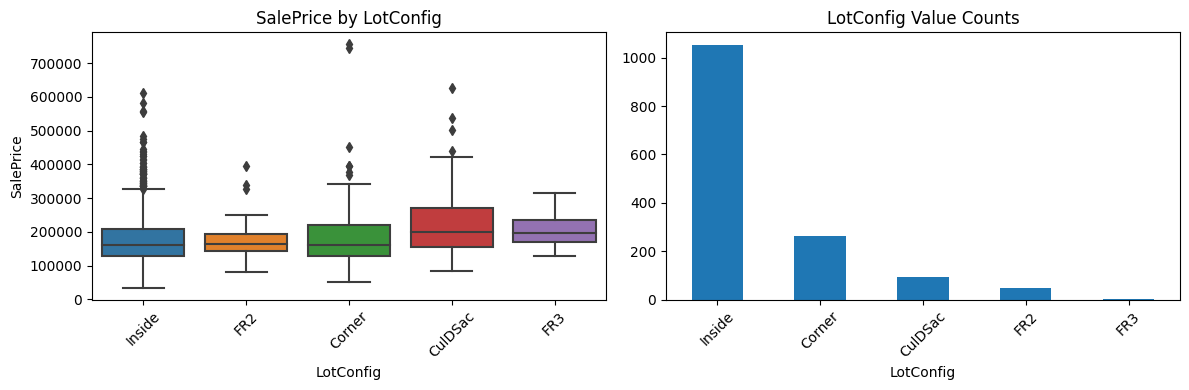

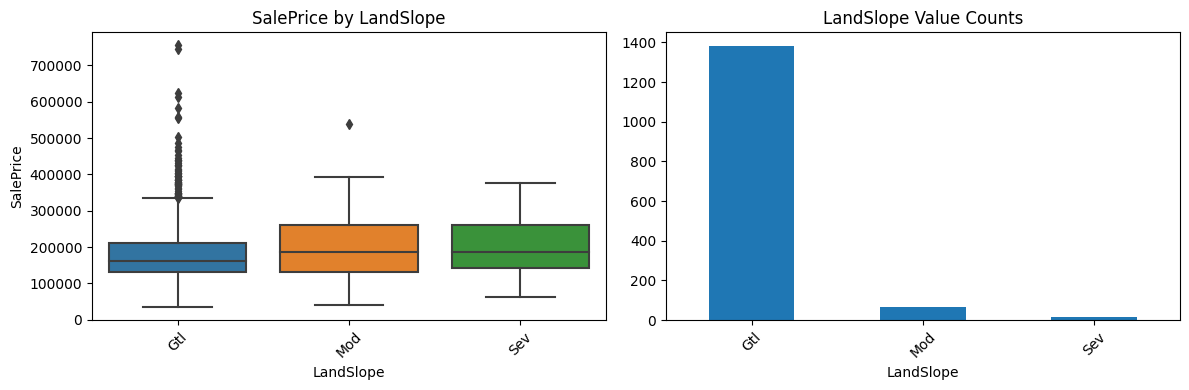

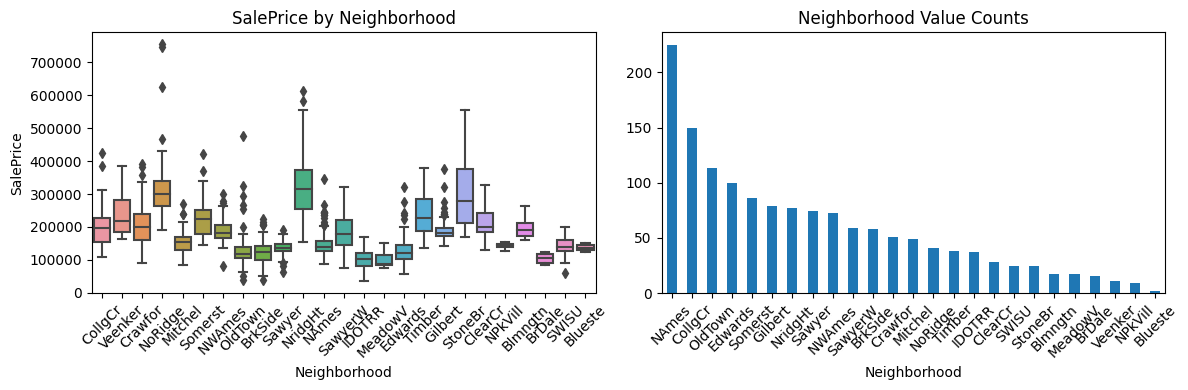

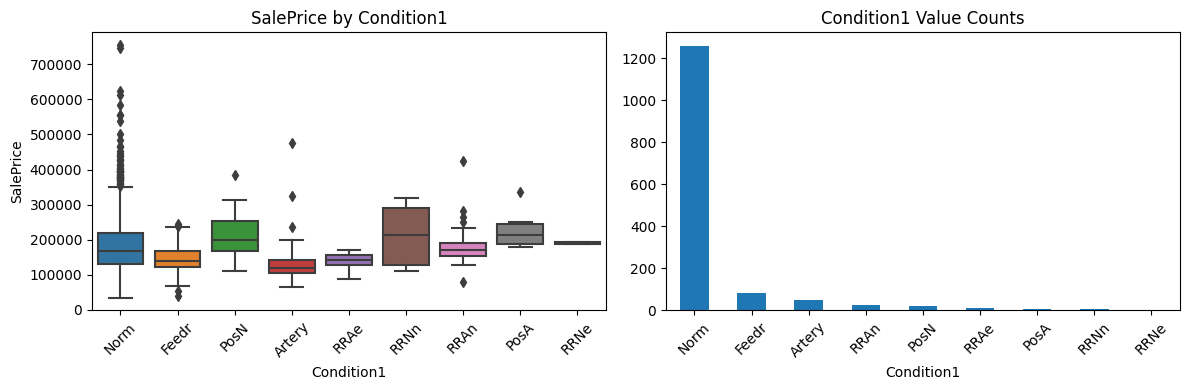

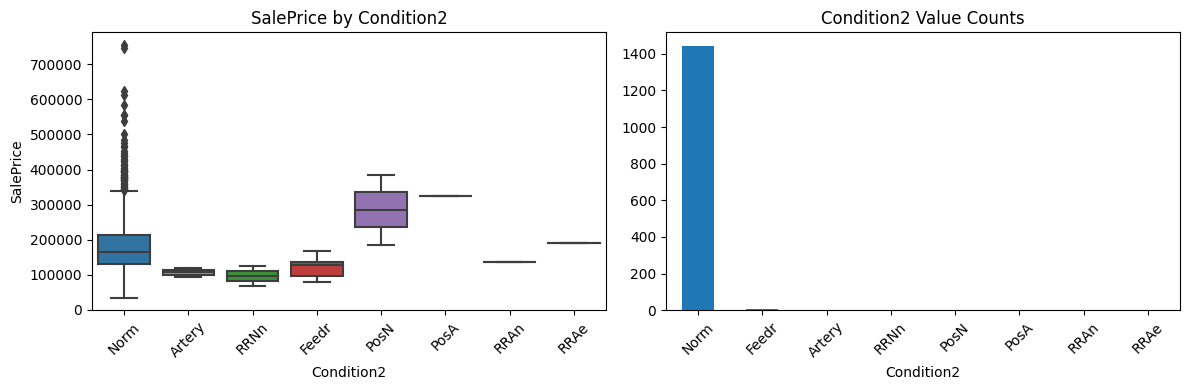

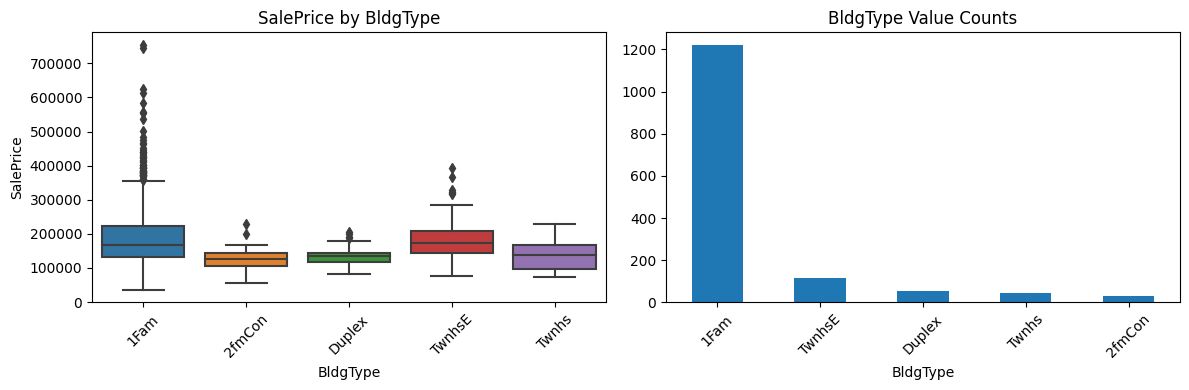

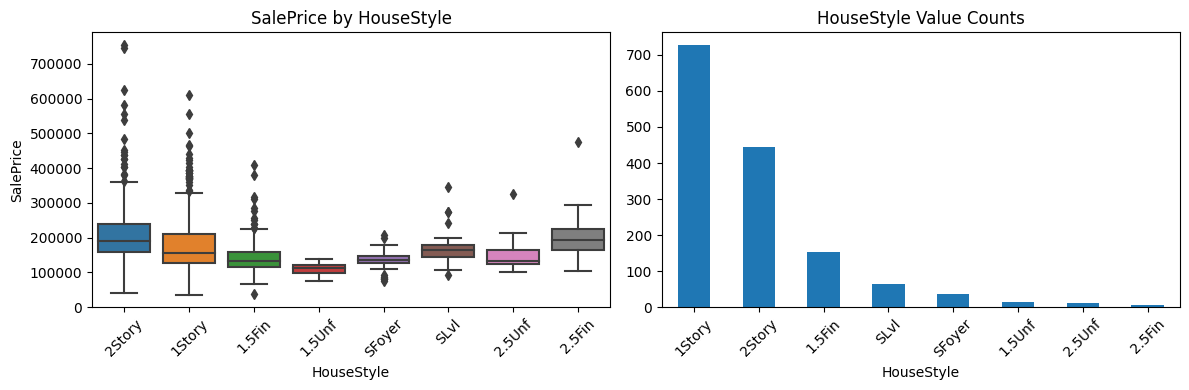

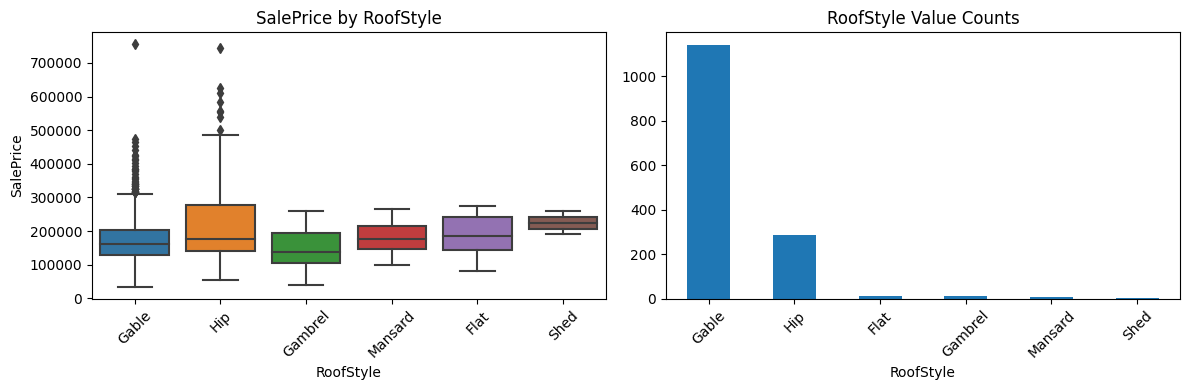

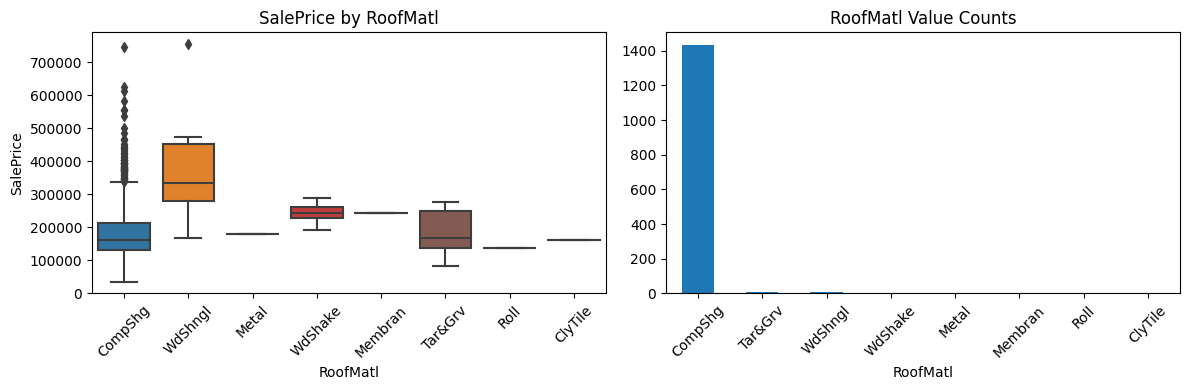

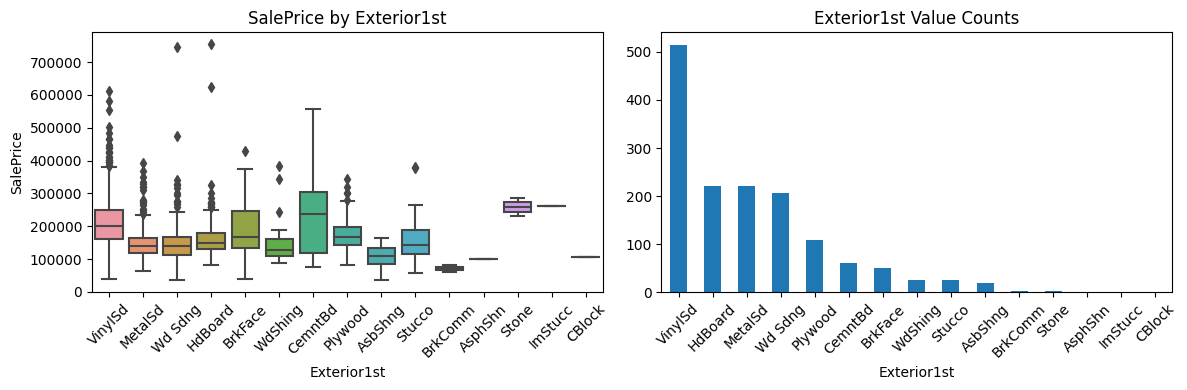

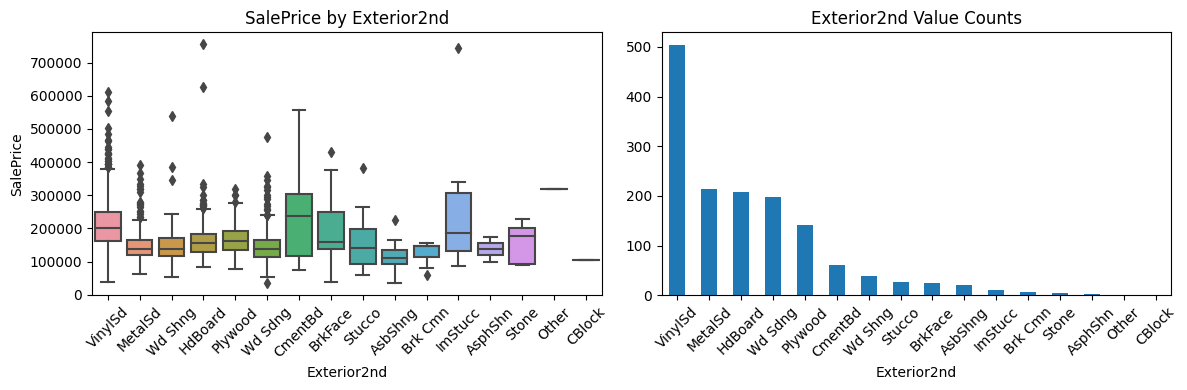

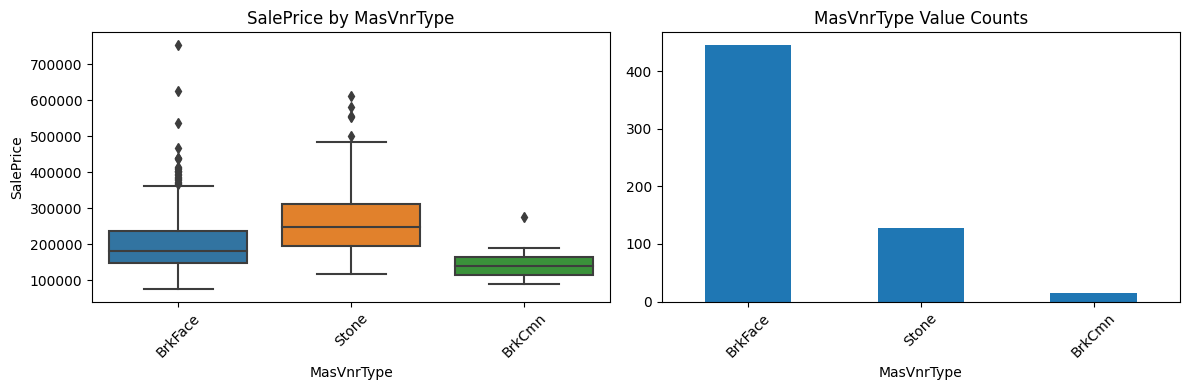

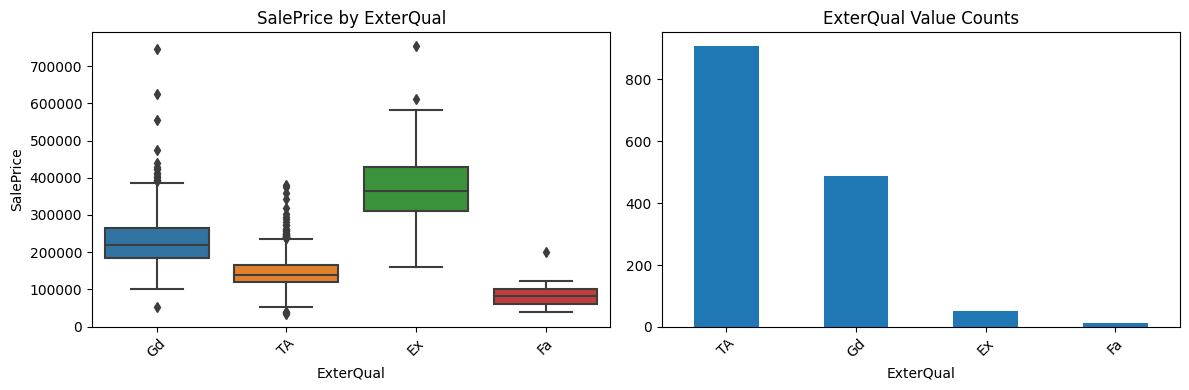

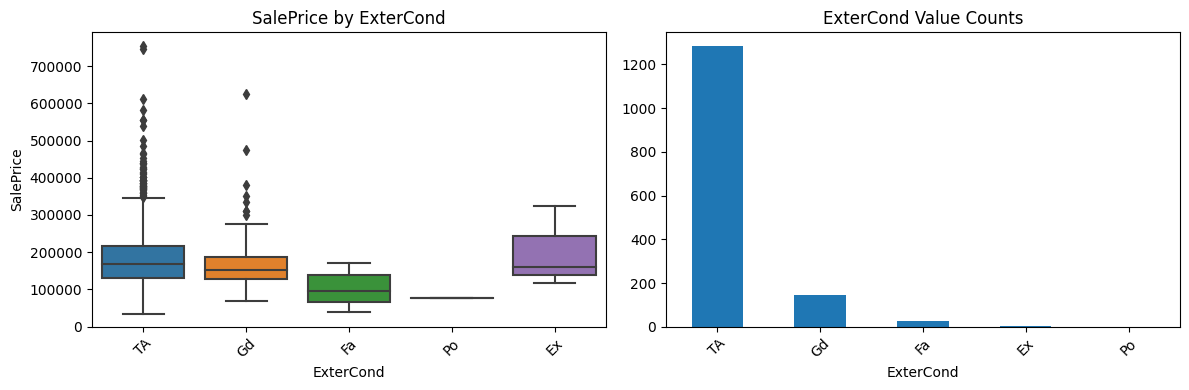

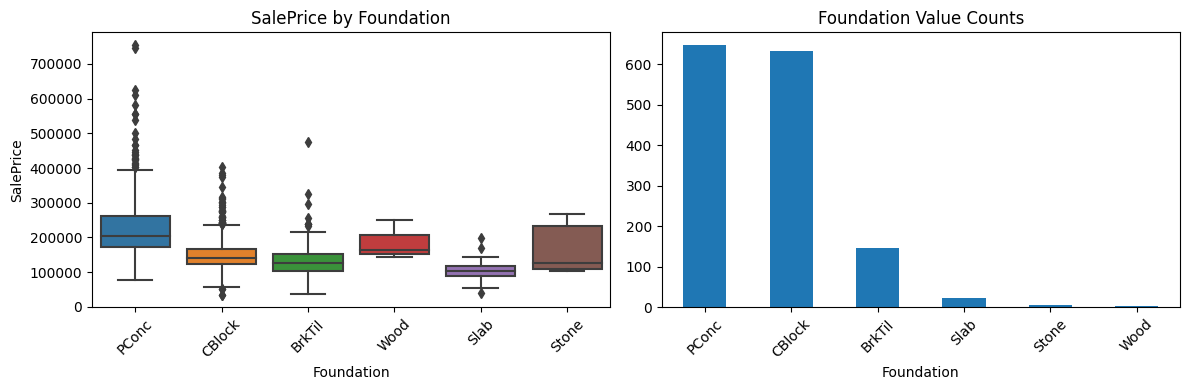

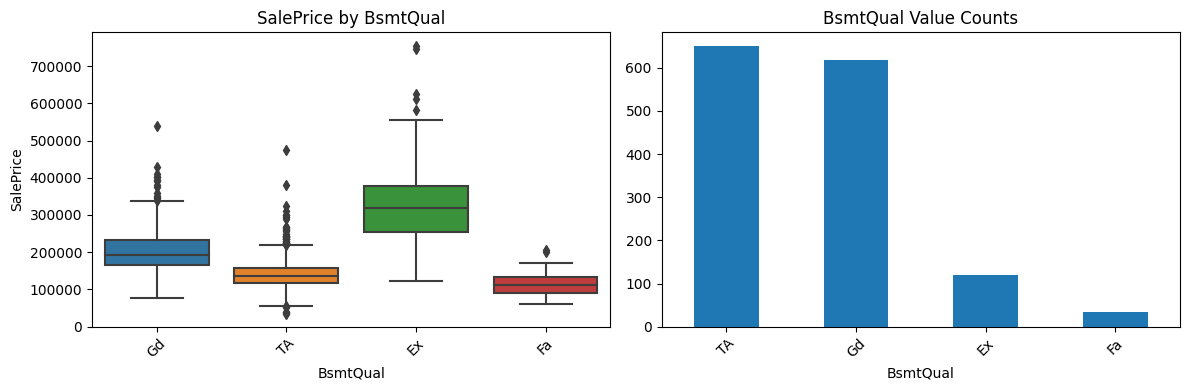

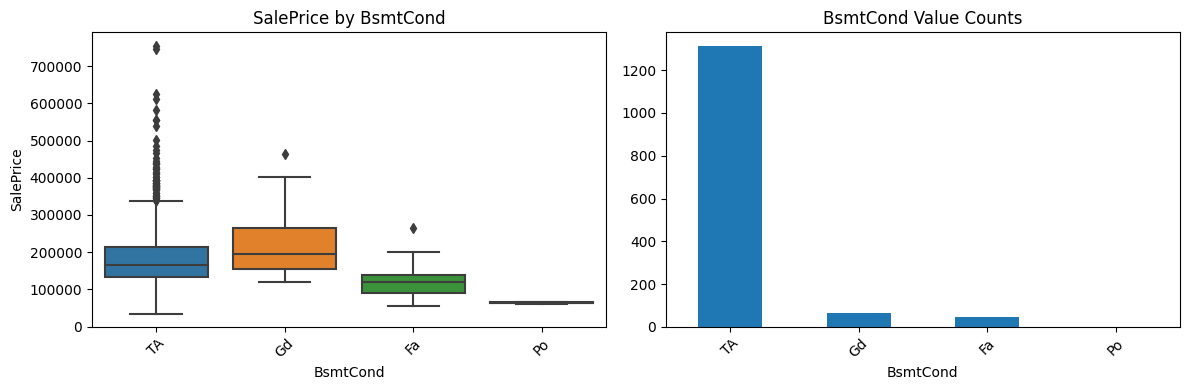

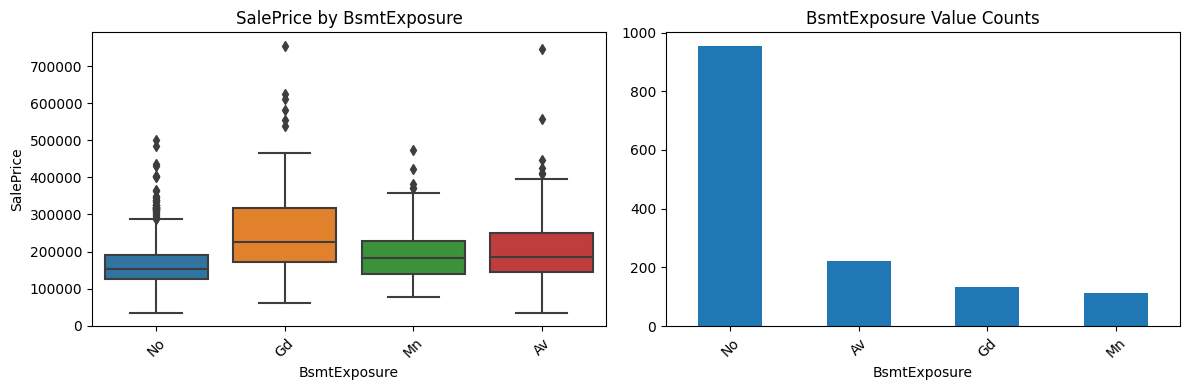

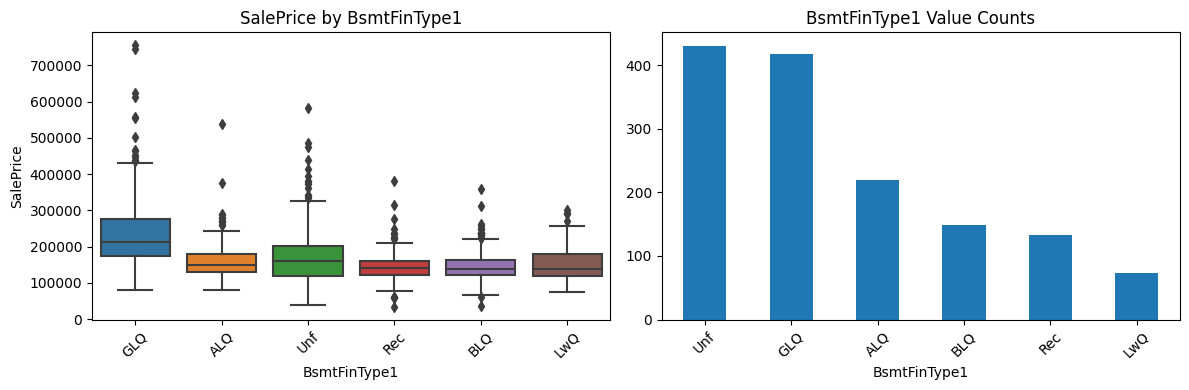

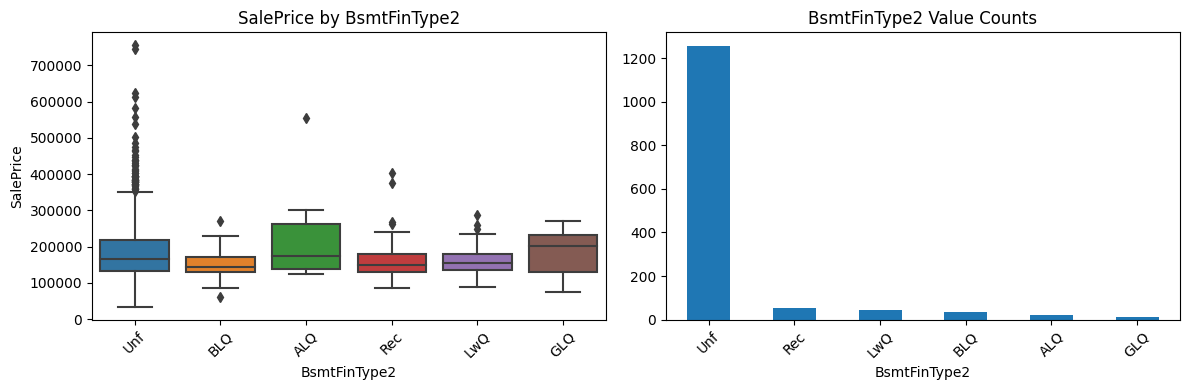

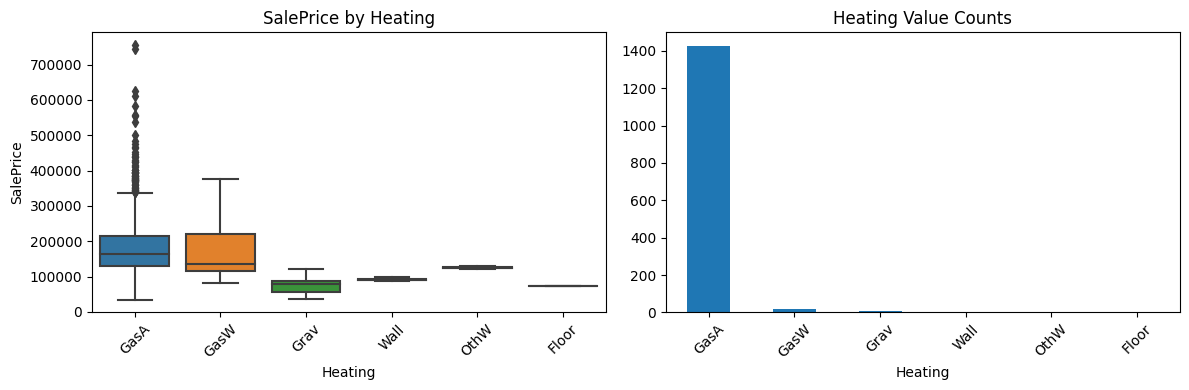

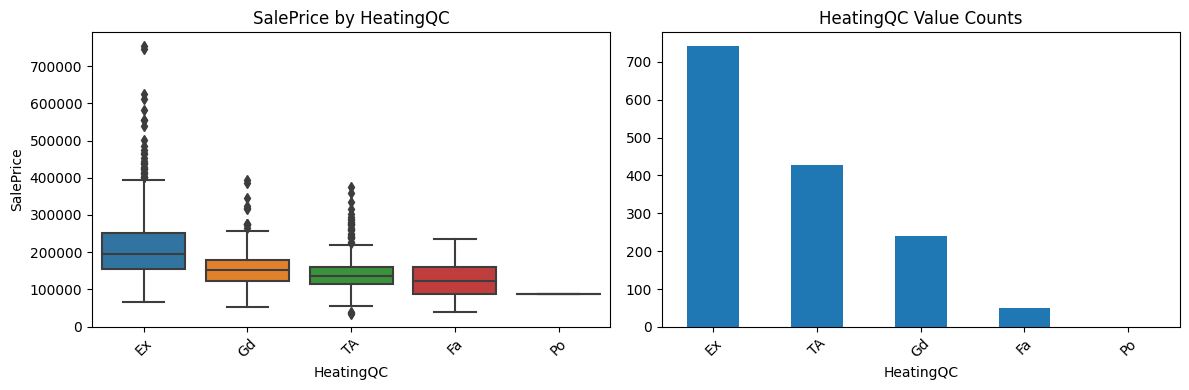

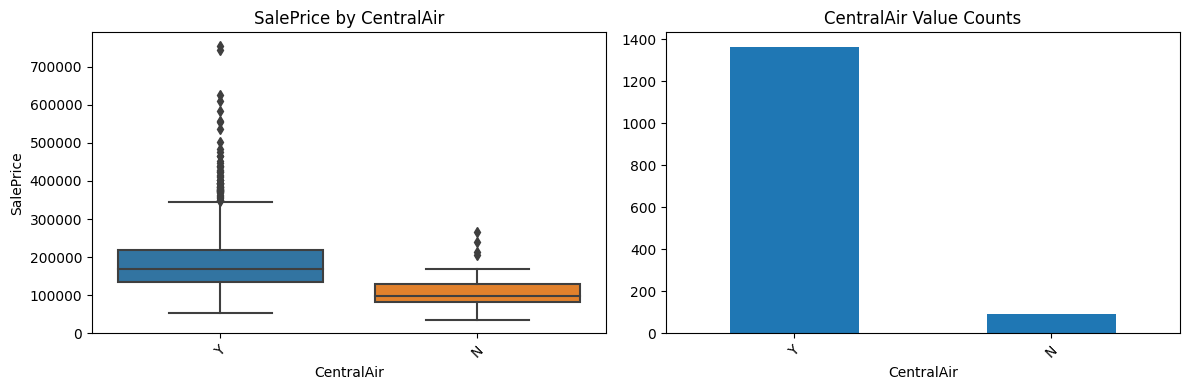

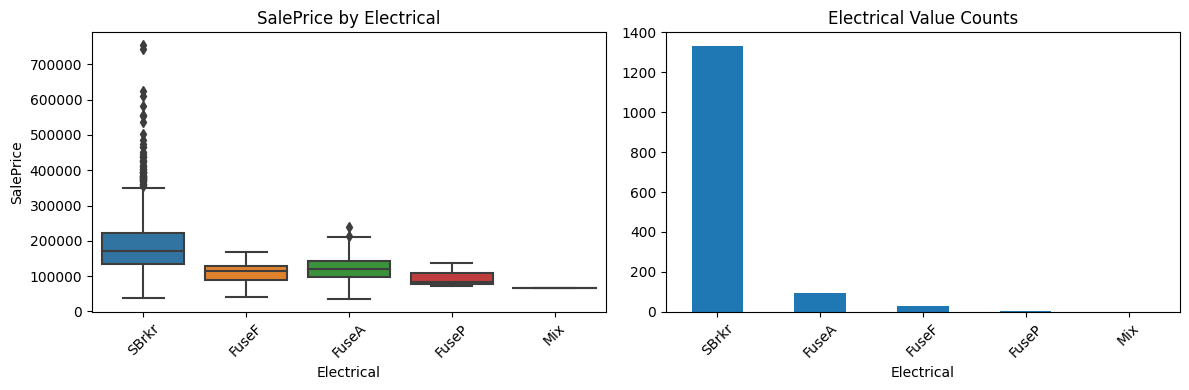

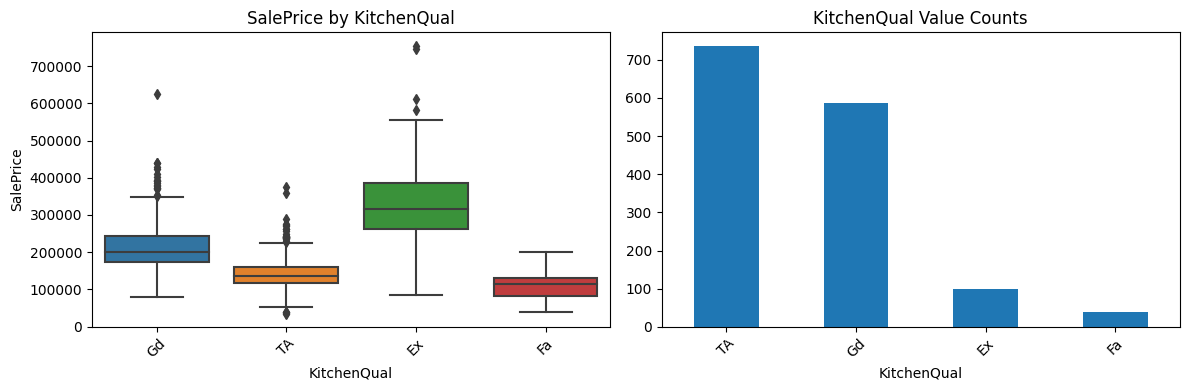

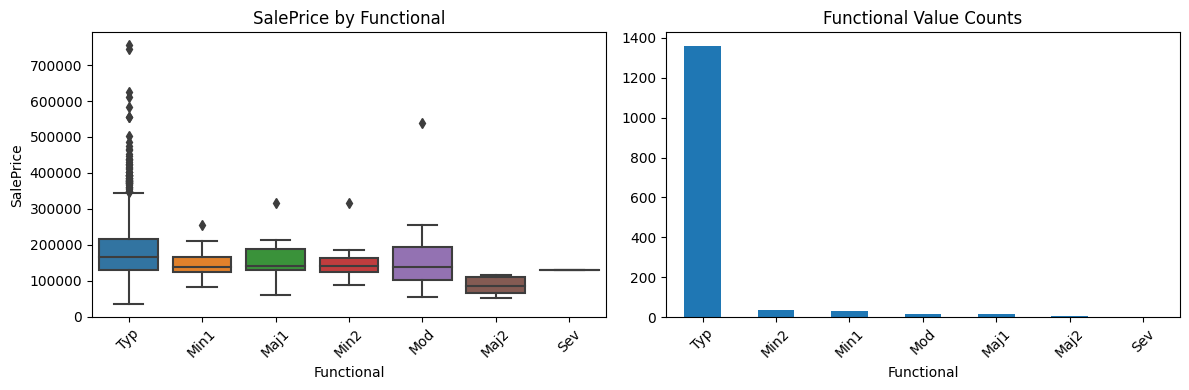

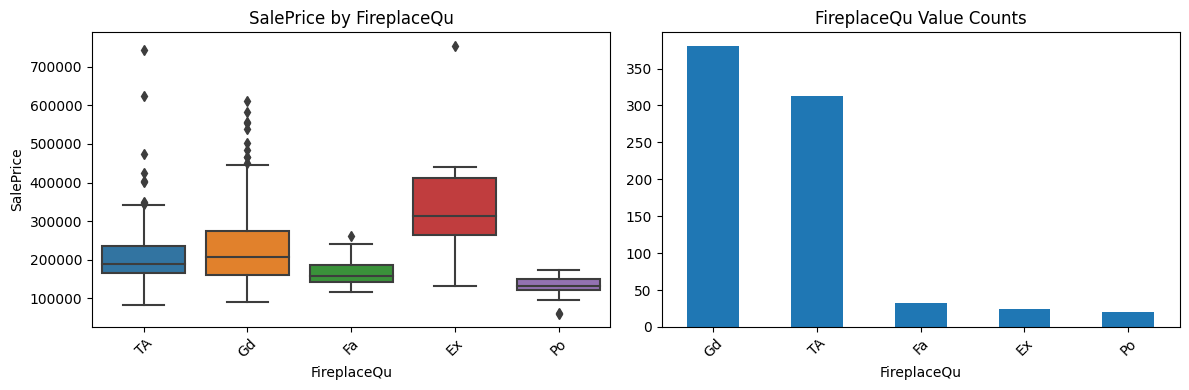

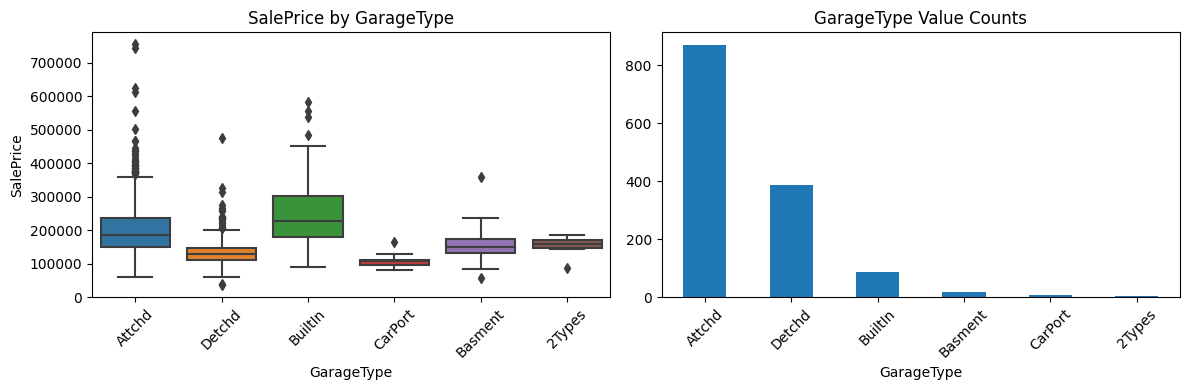

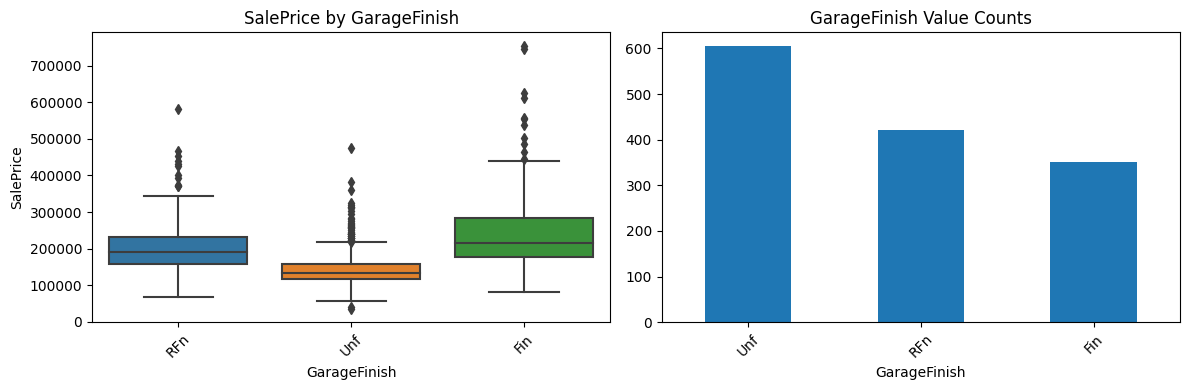

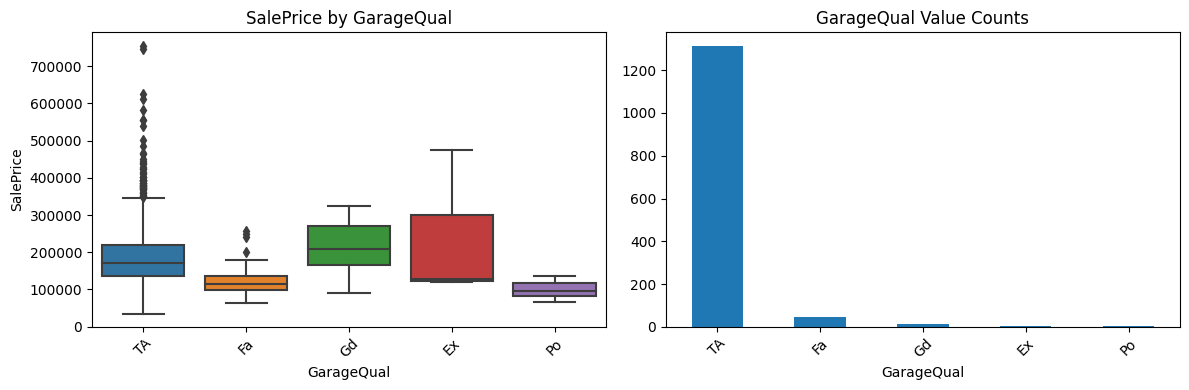

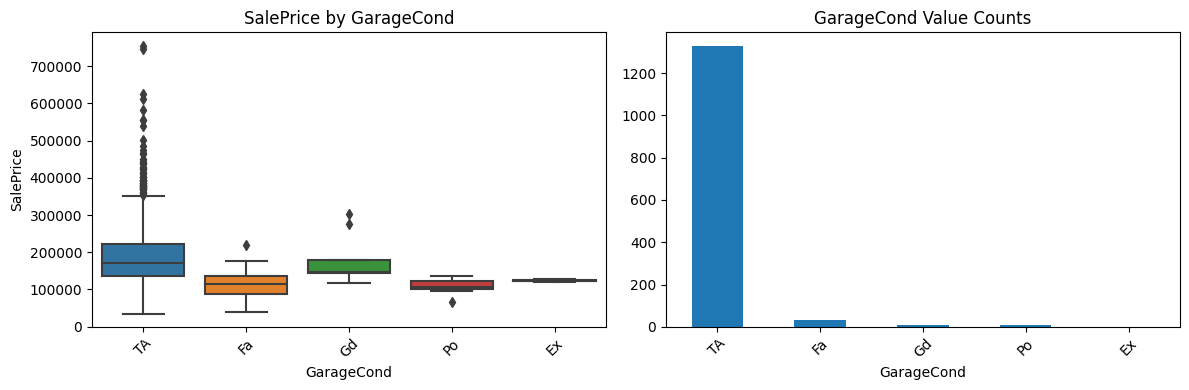

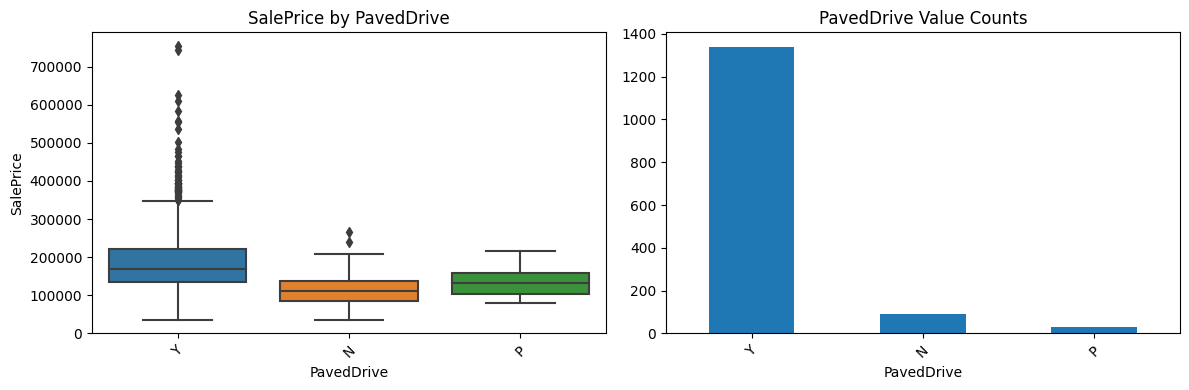

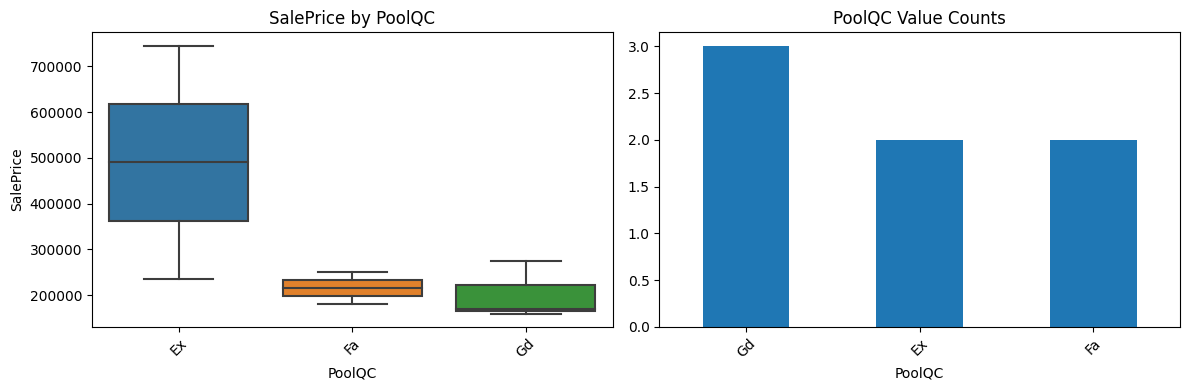

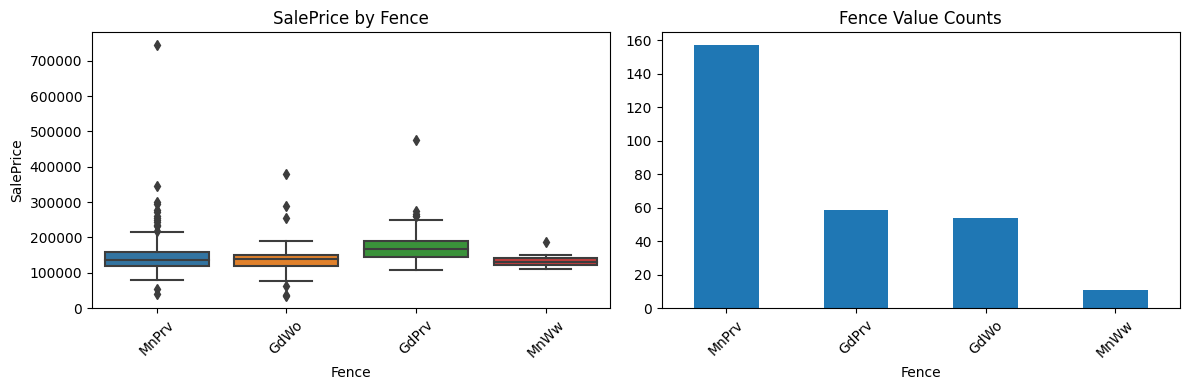

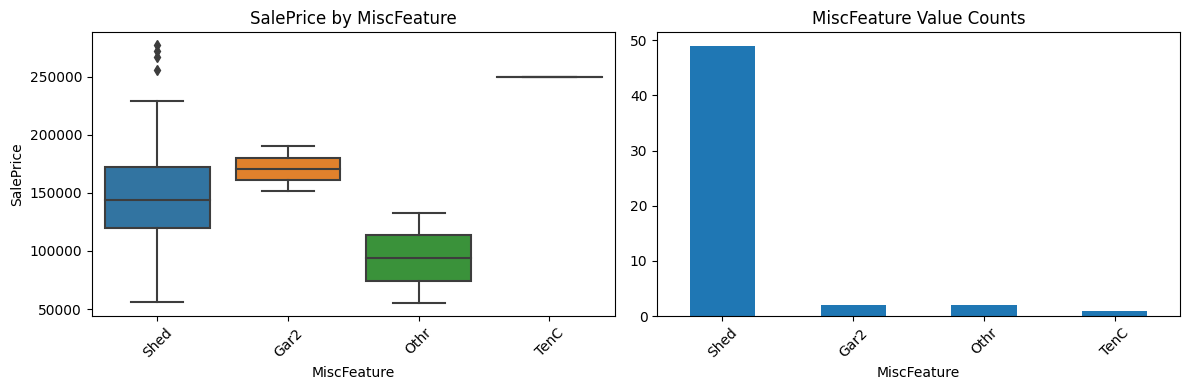

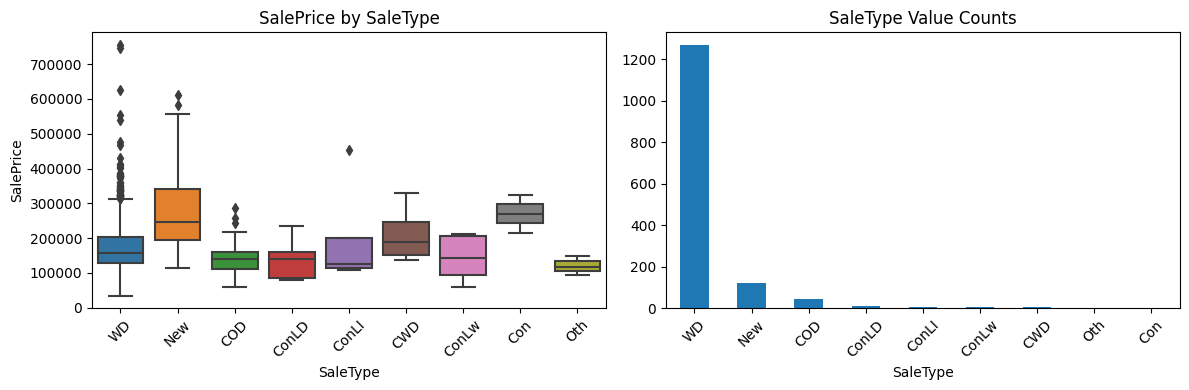

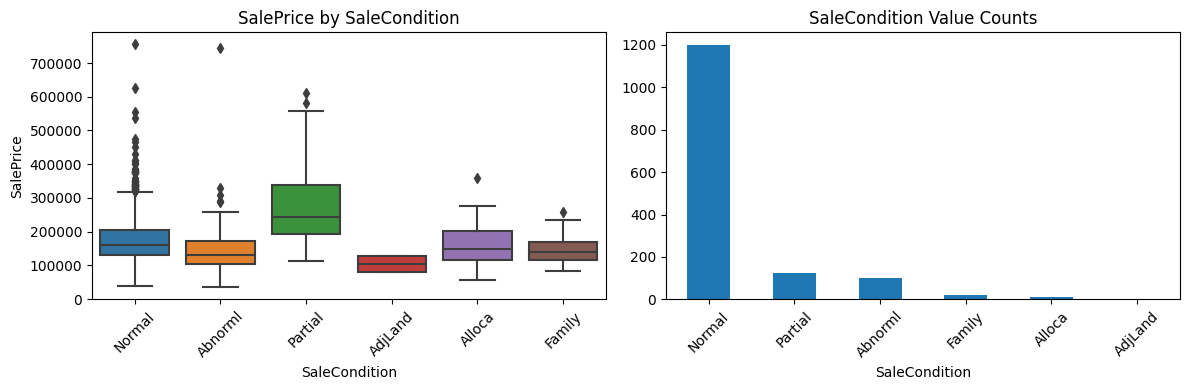

{'MSZoning': {'unique_values': 5, 'mean_target_by_category': {'FV': 214014.06153846154, 'RL': 191004.99478714162, 'RH': 131558.375, 'RM': 126316.83027522935, 'C (all)': 74528.0}, 'category_counts': {'RL': 1151, 'RM': 218, 'FV': 65, 'RH': 16, 'C (all)': 10}}, 'Street': {'unique_values': 2, 'mean_target_by_category': {'Pave': 181130.53851444292, 'Grvl': 130190.5}, 'category_counts': {'Pave': 1454, 'Grvl': 6}}, 'Alley': {'unique_values': 3, 'mean_target_by_category': {'Pave': 168000.58536585365, 'Grvl': 122219.08}, 'category_counts': {'Grvl': 50, 'Pave': 41}}, 'LotShape': {'unique_values': 4, 'mean_target_by_category': {'IR2': 239833.36585365853, 'IR3': 216036.5, 'IR1': 206101.6652892562, 'Reg': 164754.81837837838}, 'category_counts': {'Reg': 925, 'IR1': 484, 'IR2': 41, 'IR3': 10}}, 'LandContour': {'unique_values': 4, 'mean_target_by_category': {'HLS': 231533.94, 'Low': 203661.11111111112, 'Lvl': 180183.74675819985, 'Bnk': 143104.07936507938}, 'category_counts': {'Lvl': 1311, 'Bnk': 63, '

In [22]:
answer_question_with_function_calling_enhanced("I want to see the relation between the categorcial features and target feature")

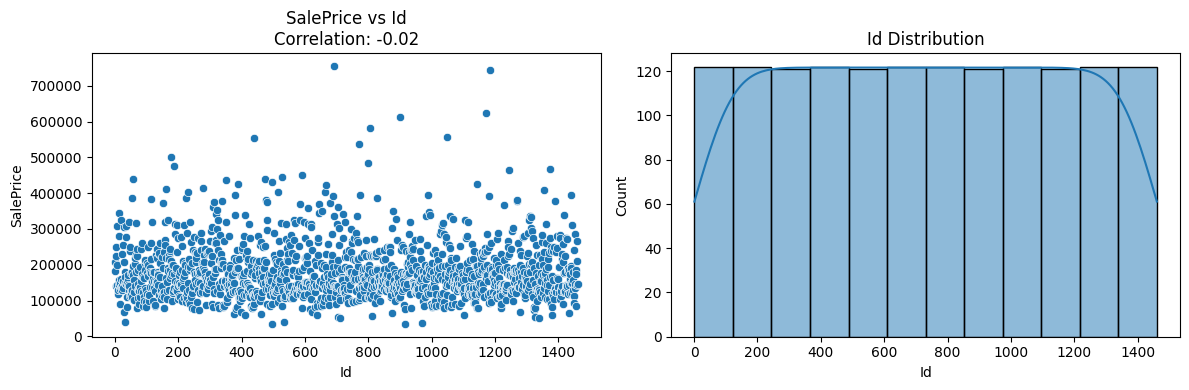

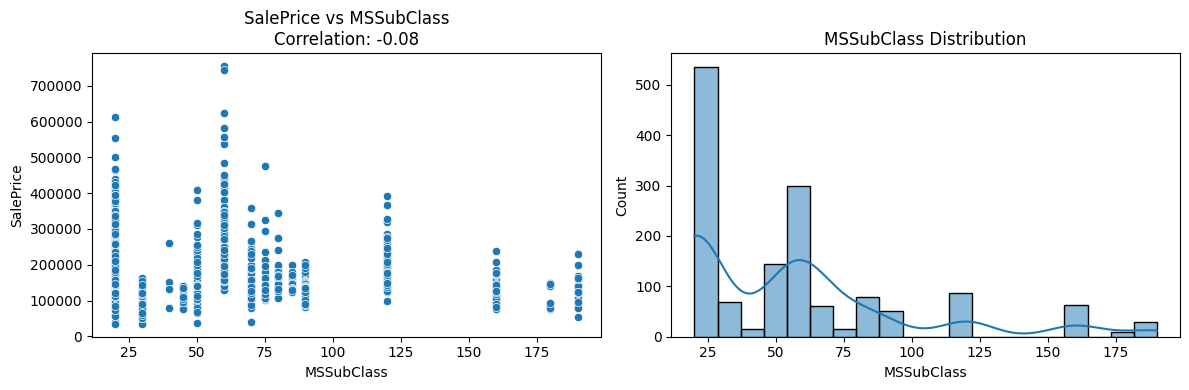

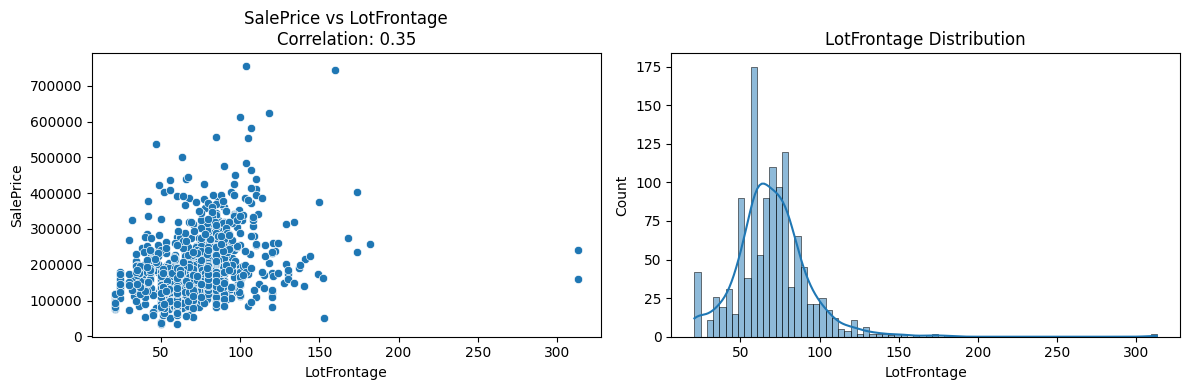

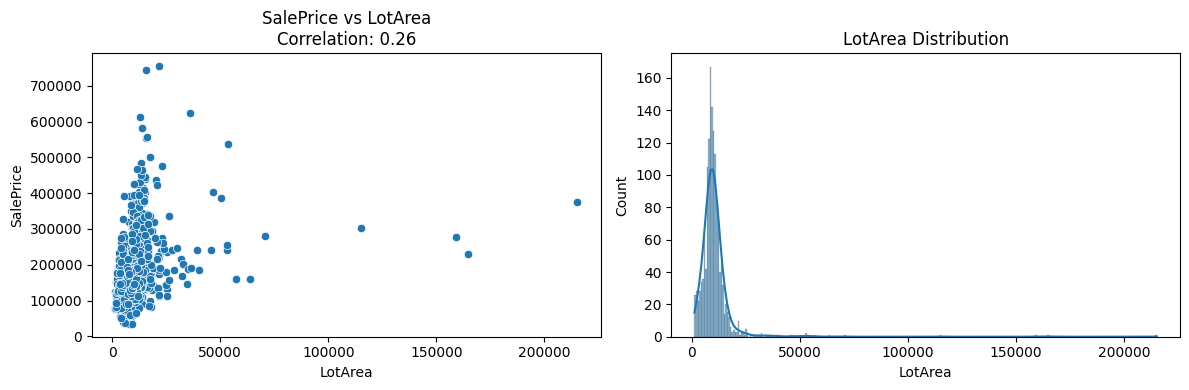

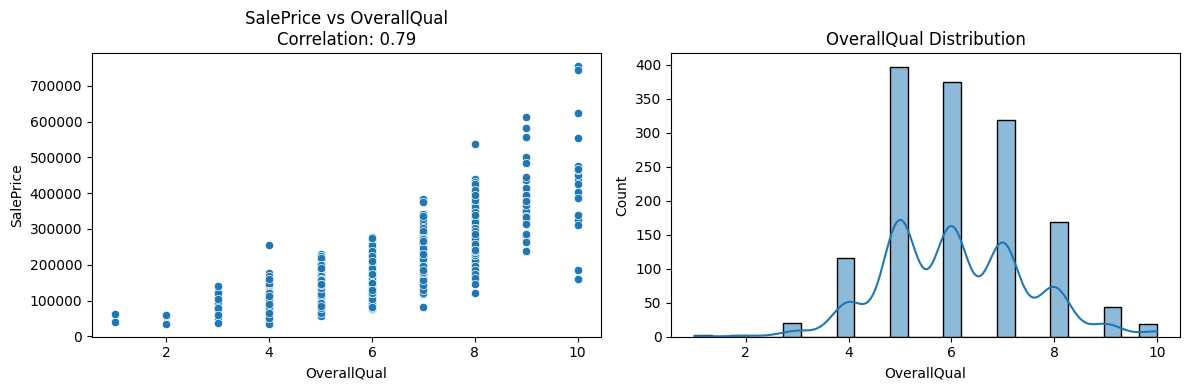

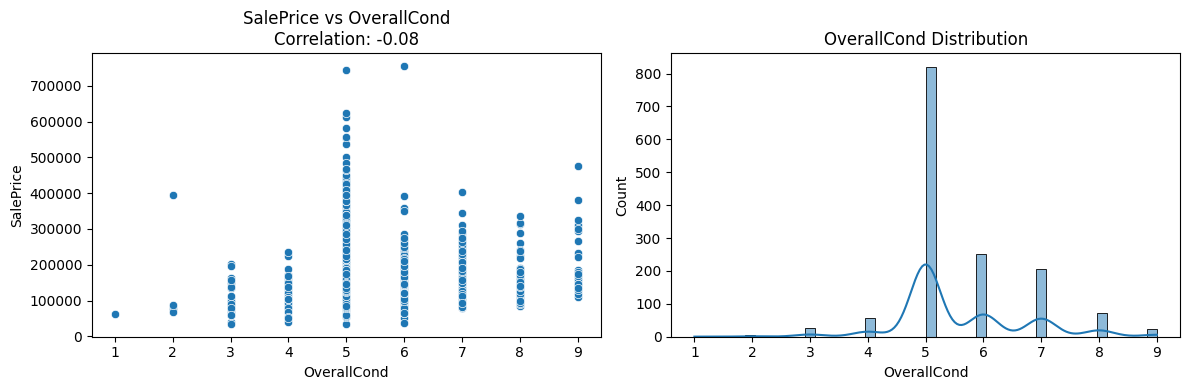

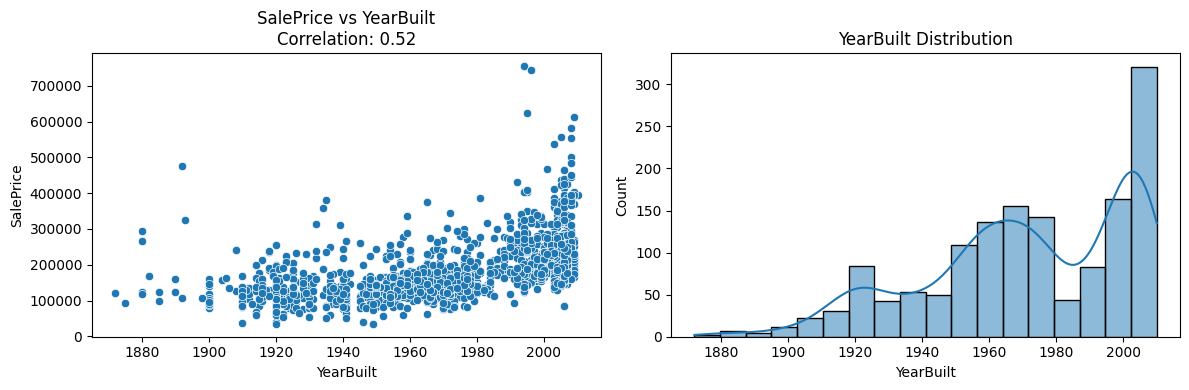

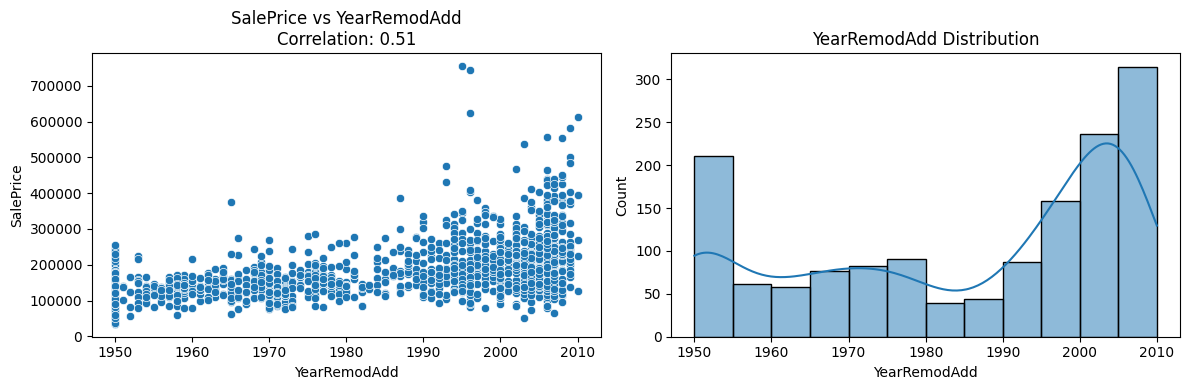

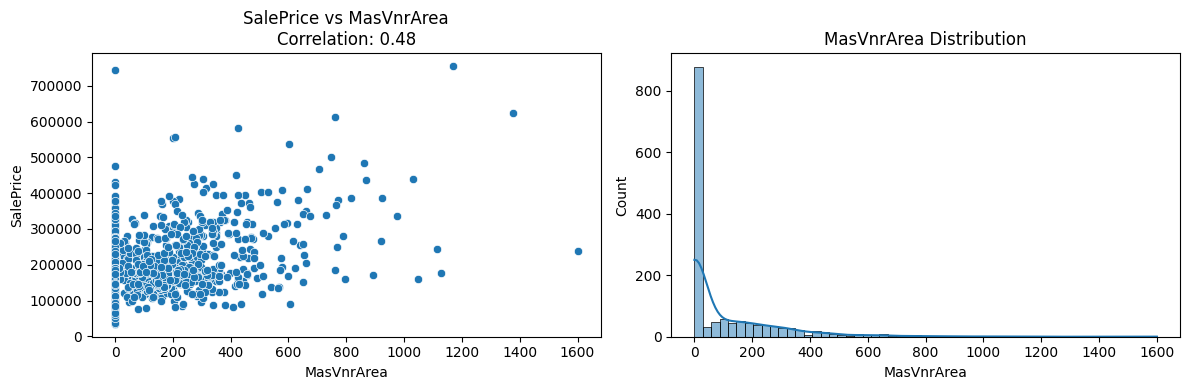

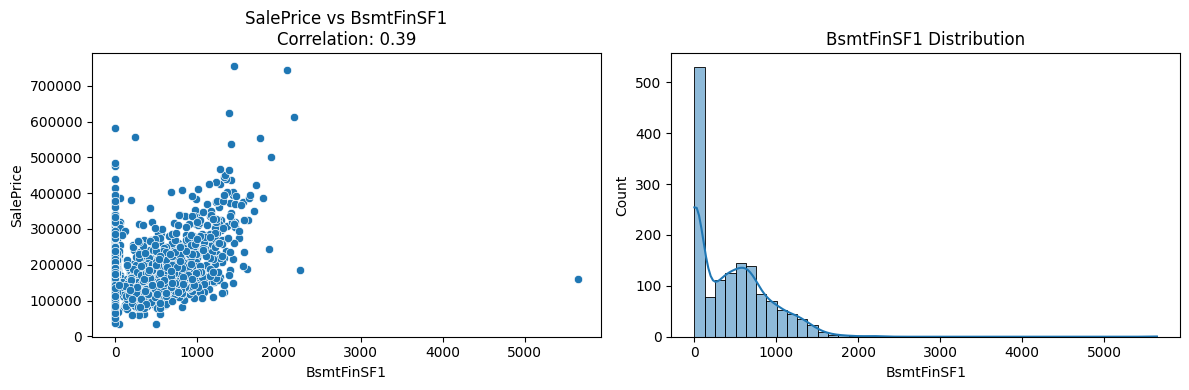

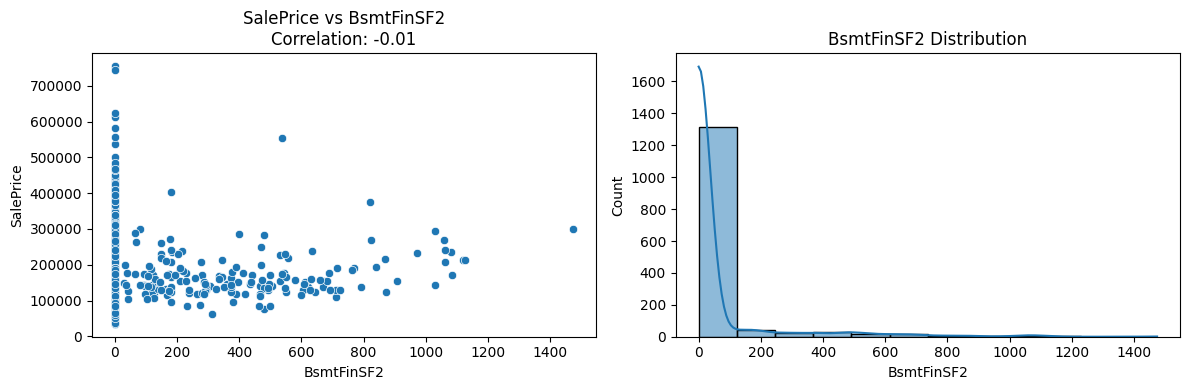

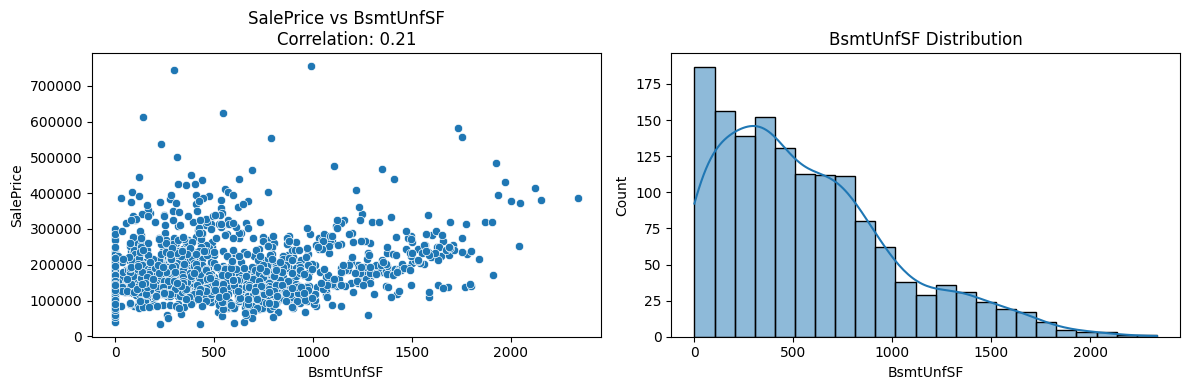

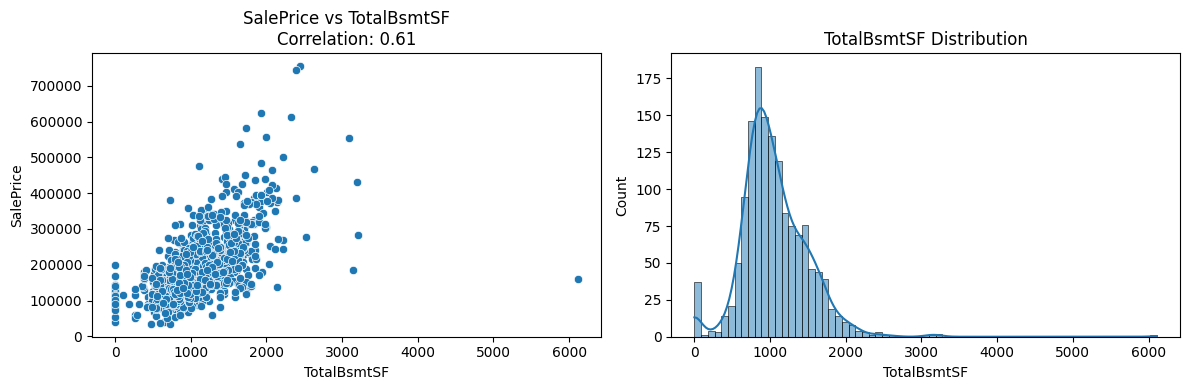

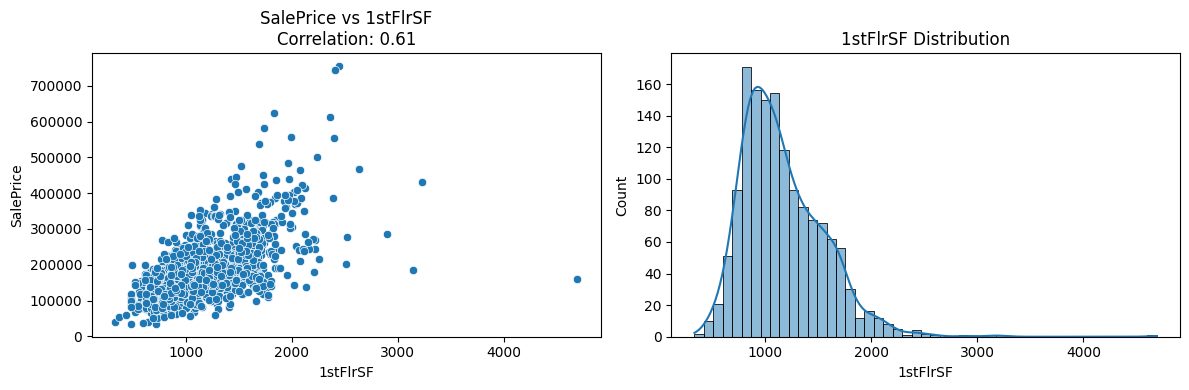

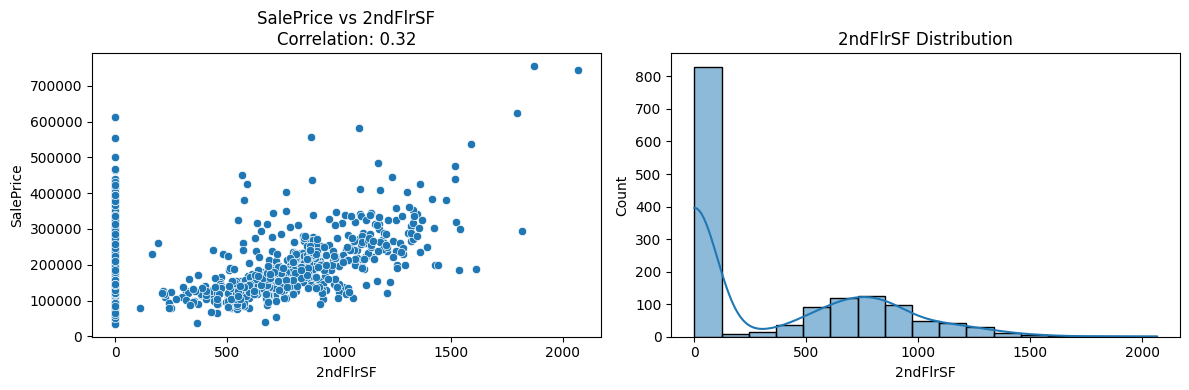

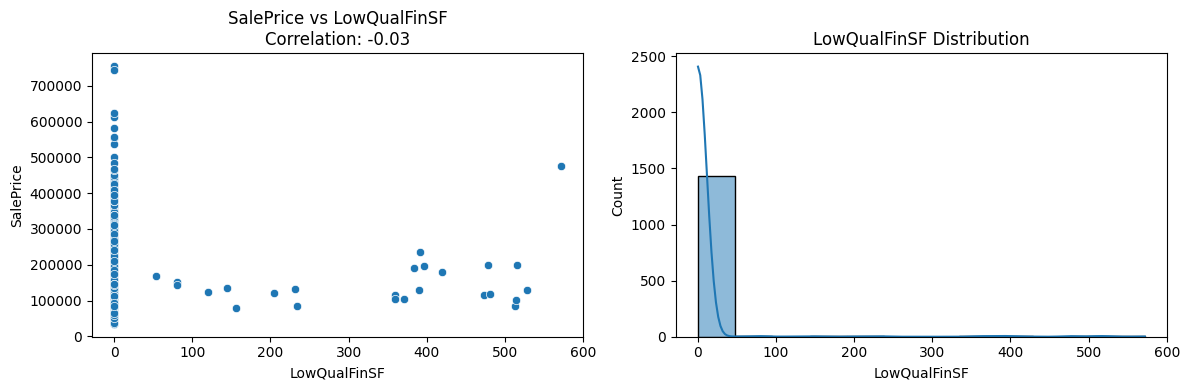

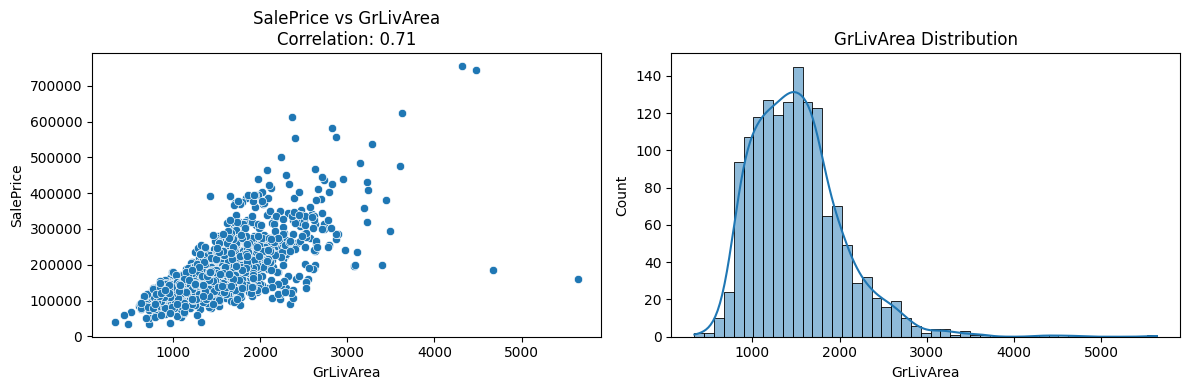

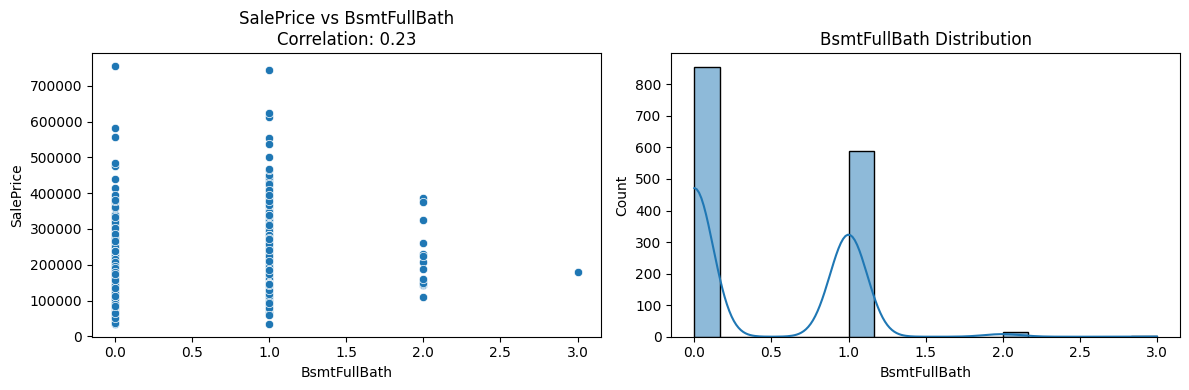

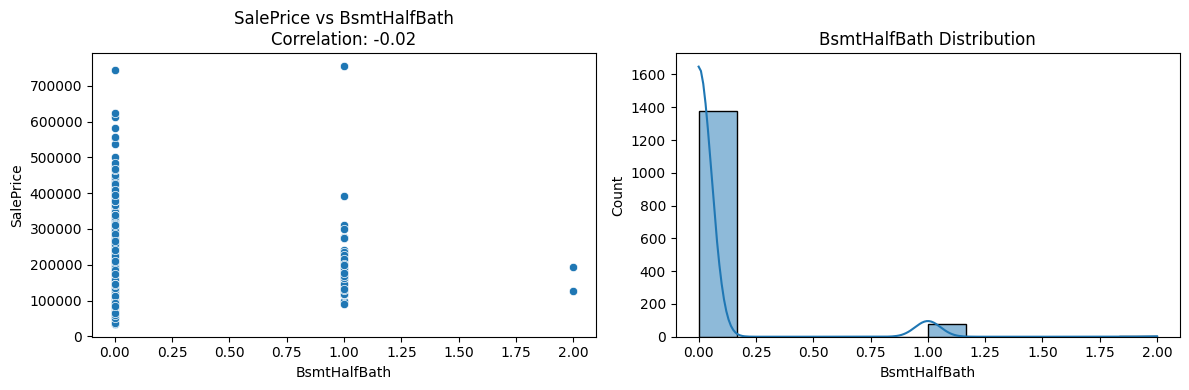

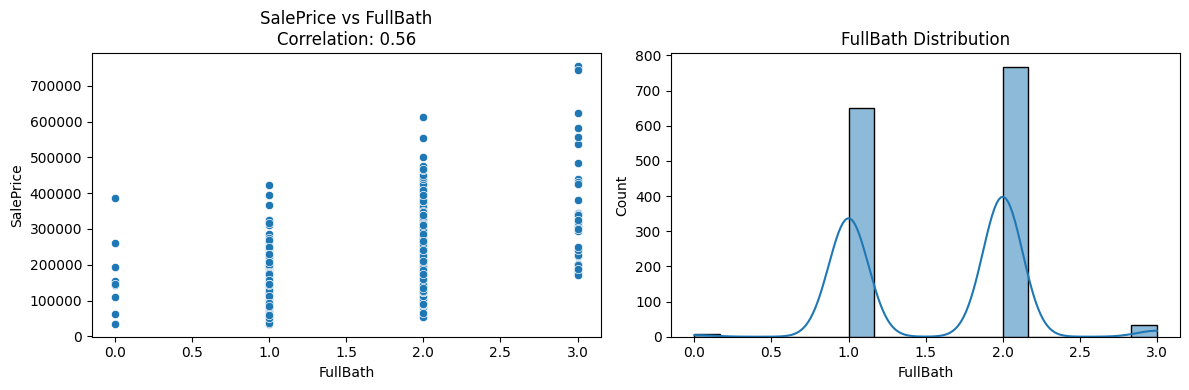

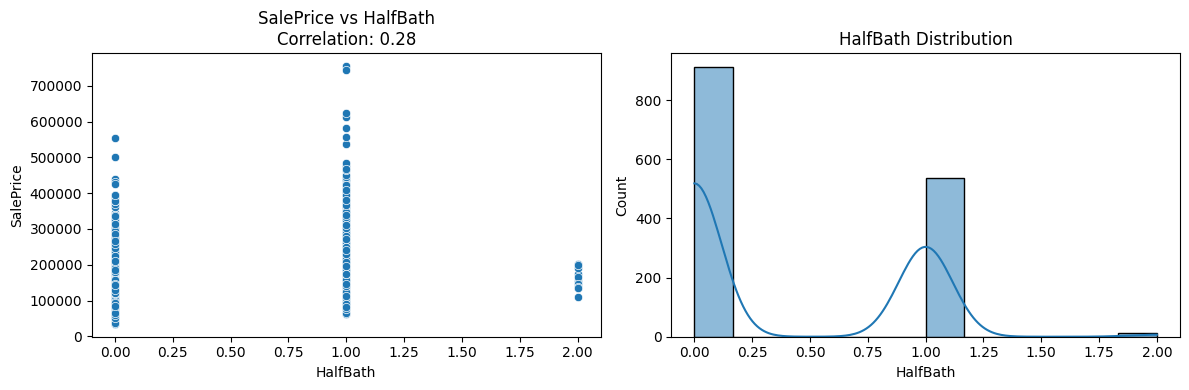

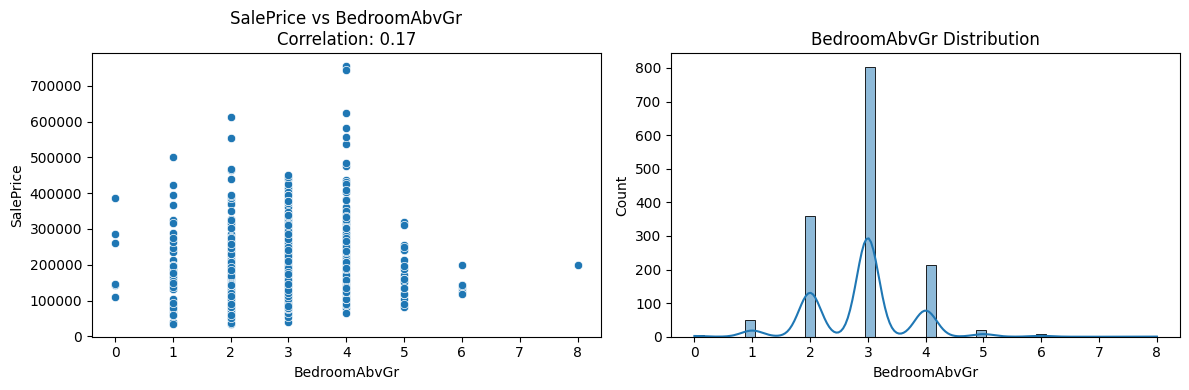

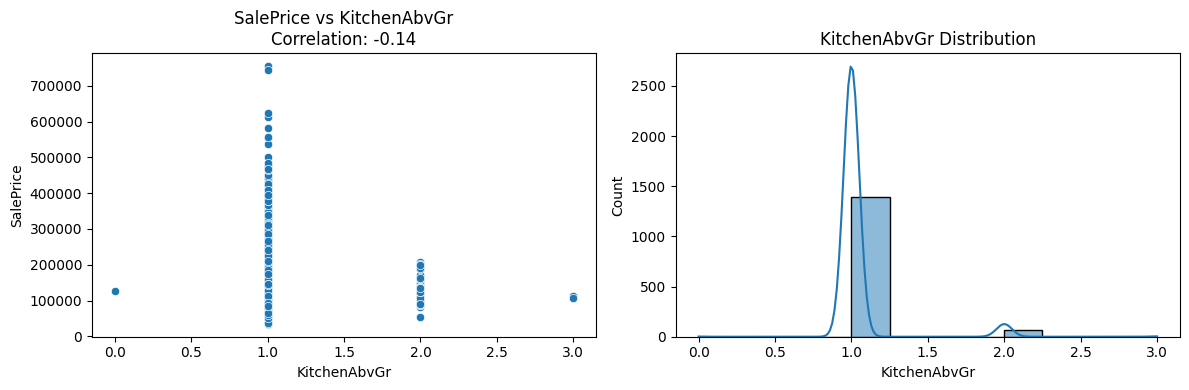

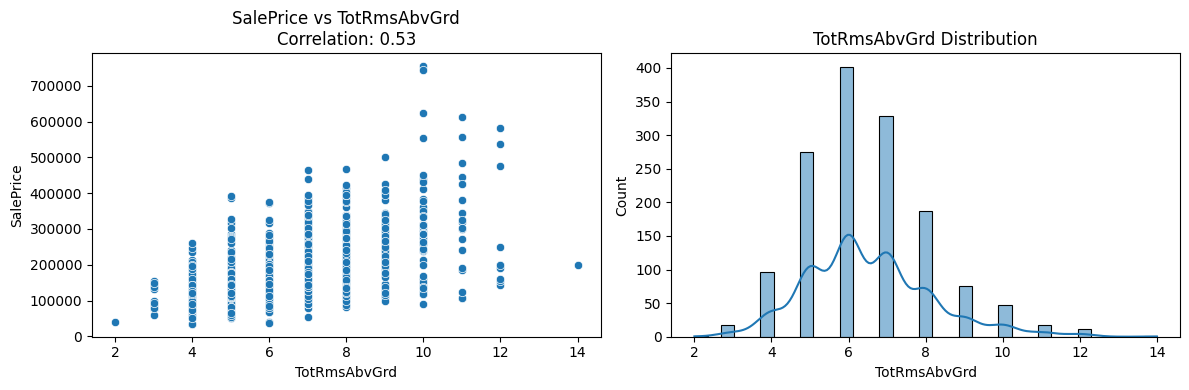

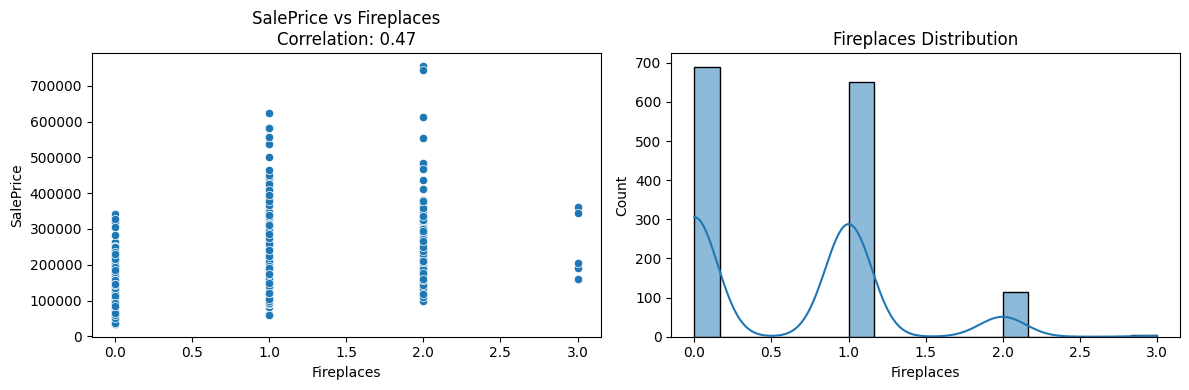

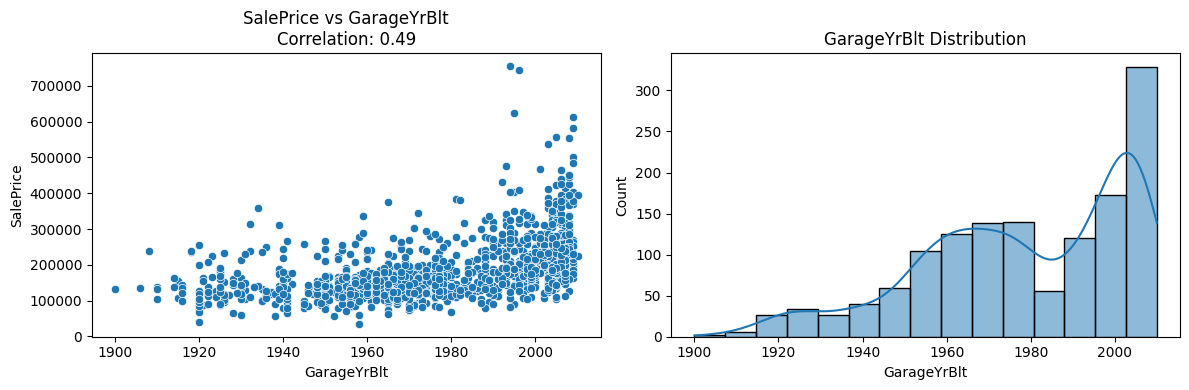

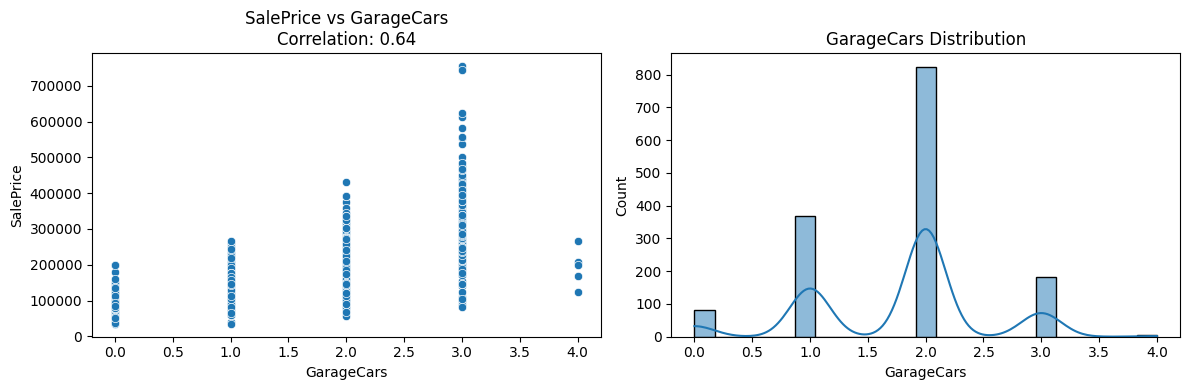

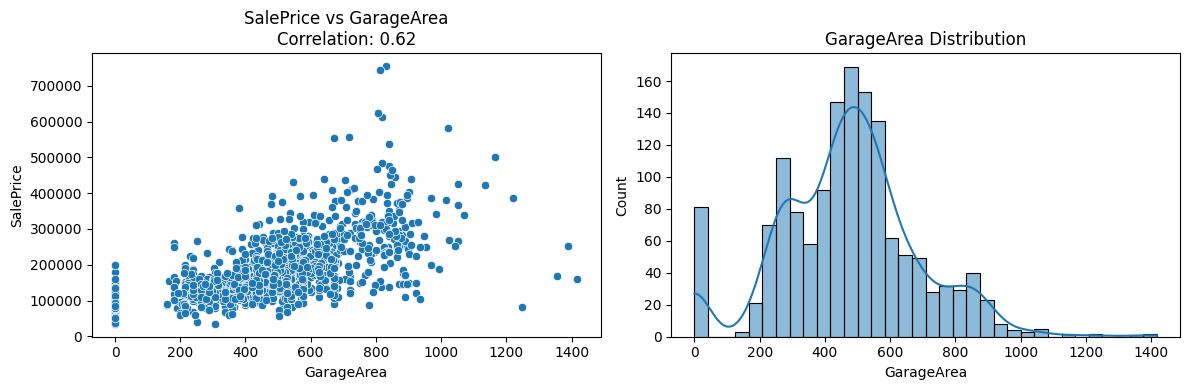

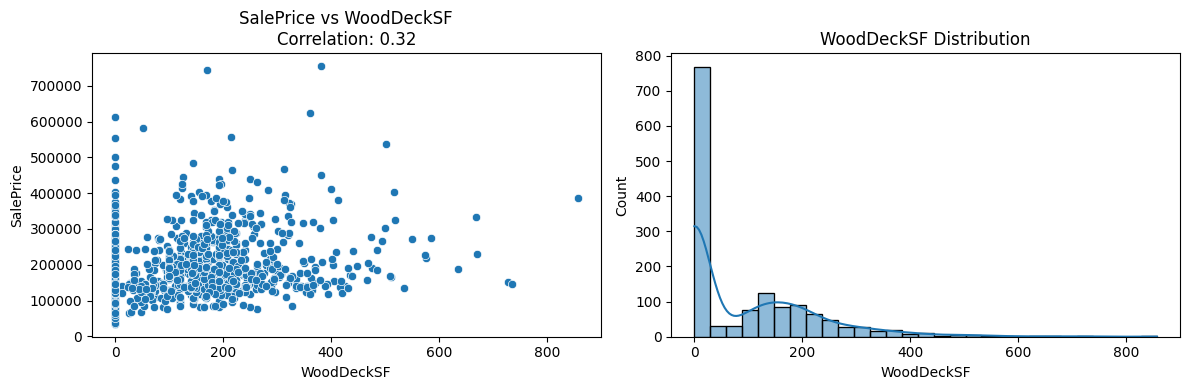

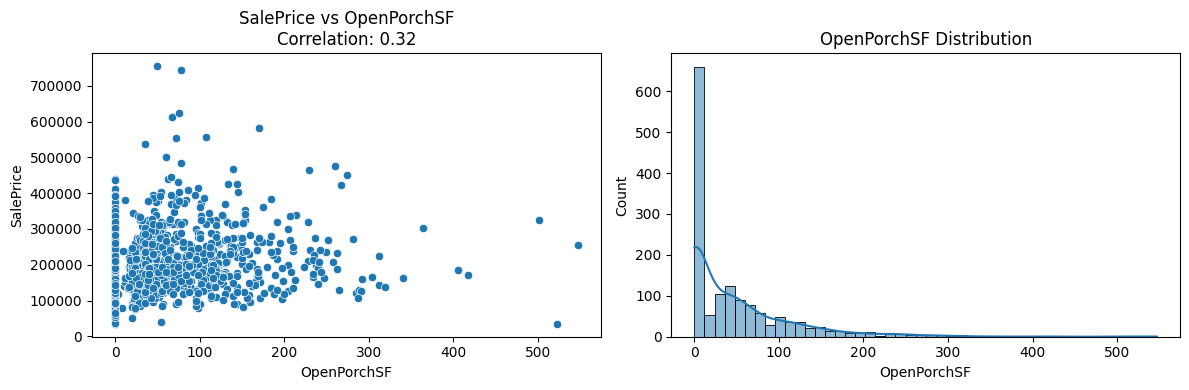

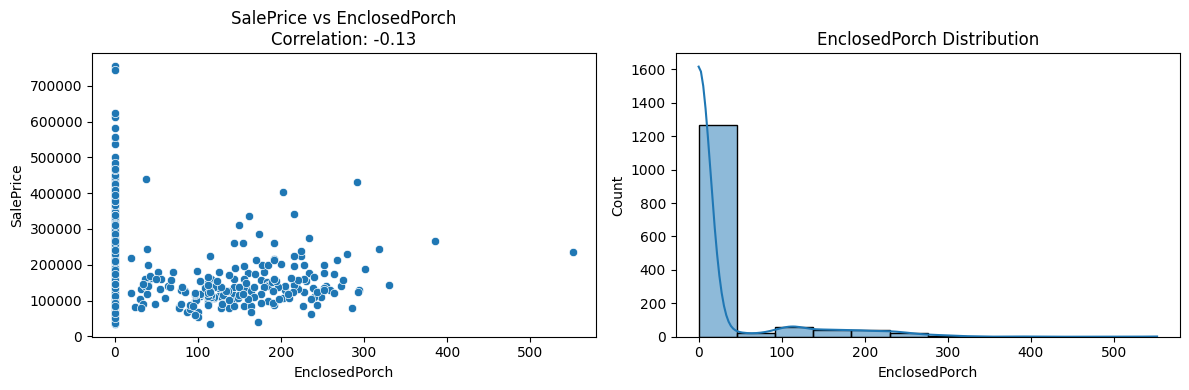

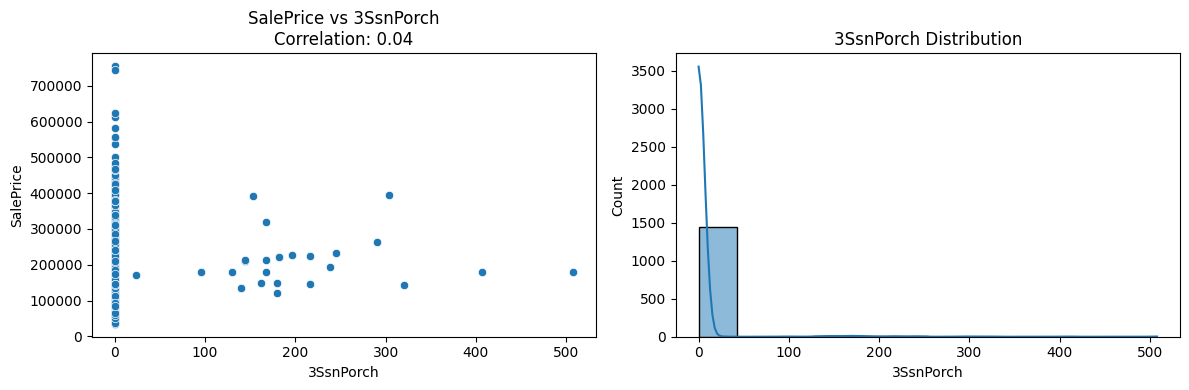

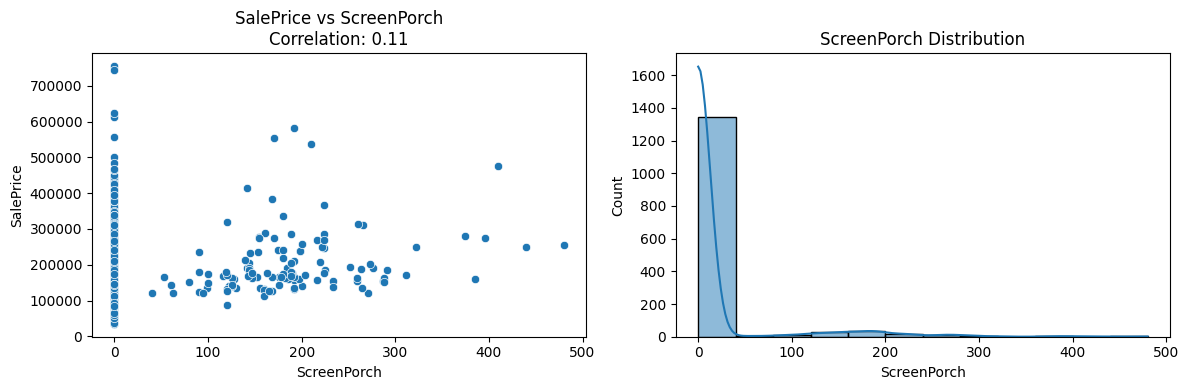

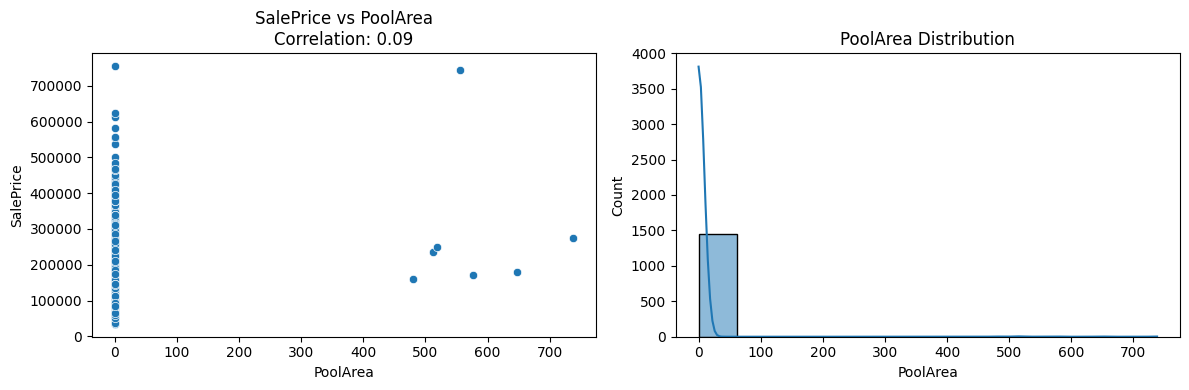

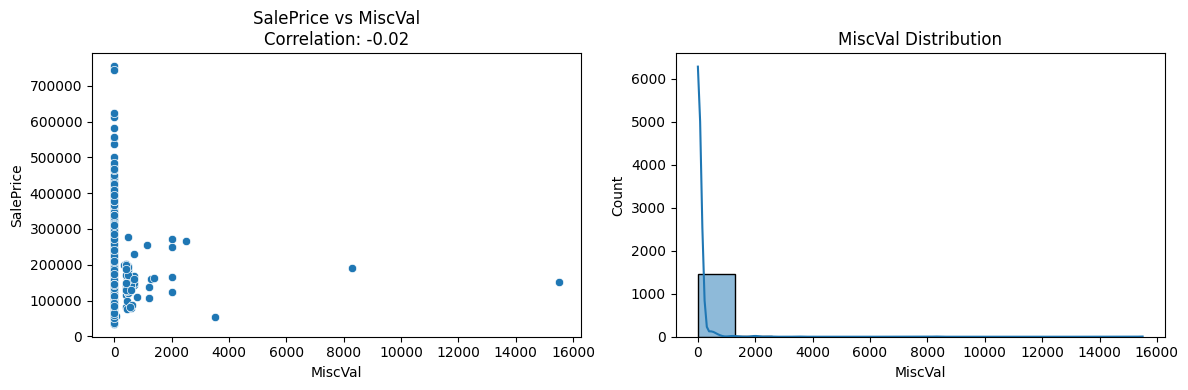

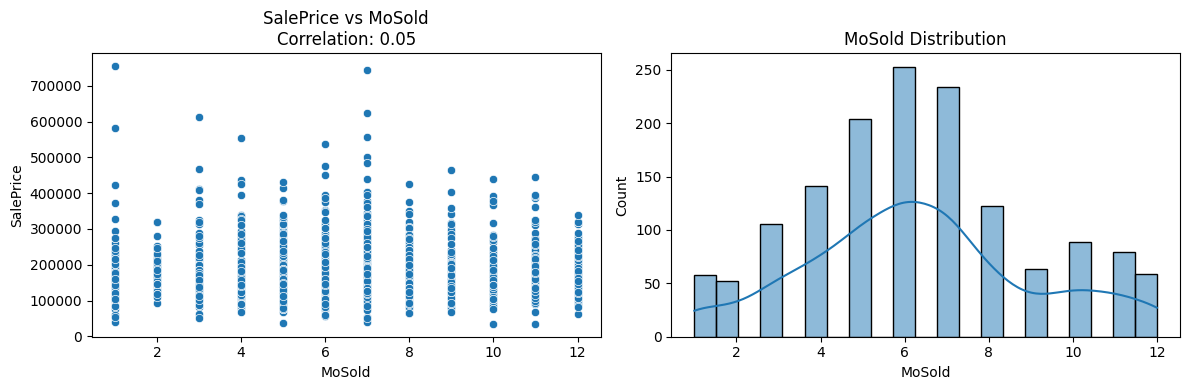

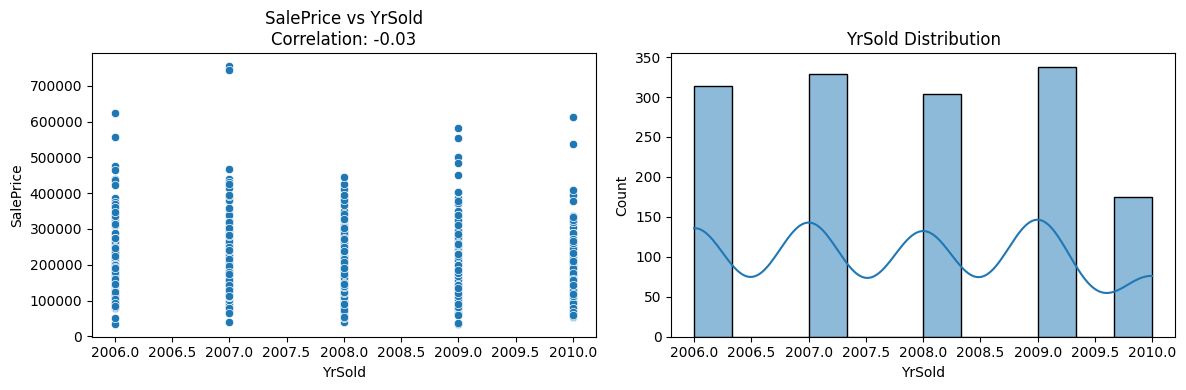

{'Id': {'correlation': -0.021916719443431116, 'skewness': 0.0, 'missing_values': 0}, 'MSSubClass': {'correlation': -0.08428413512659529, 'skewness': 1.4062101115313512, 'missing_values': 0}, 'LotFrontage': {'correlation': 0.3517990965706781, 'skewness': 2.160865994705543, 'missing_values': 259}, 'LotArea': {'correlation': 0.2638433538714056, 'skewness': 12.195142125084478, 'missing_values': 0}, 'OverallQual': {'correlation': 0.7909816005838051, 'skewness': 0.2167209765258641, 'missing_values': 0}, 'OverallCond': {'correlation': -0.07785589404867806, 'skewness': 0.6923552135520978, 'missing_values': 0}, 'YearBuilt': {'correlation': 0.5228973328794971, 'skewness': -0.612830724202899, 'missing_values': 0}, 'YearRemodAdd': {'correlation': 0.5071009671113864, 'skewness': -0.5030444967597948, 'missing_values': 0}, 'MasVnrArea': {'correlation': 0.4774930470957166, 'skewness': 2.6663261001607435, 'missing_values': 8}, 'BsmtFinSF1': {'correlation': 0.3864198062421531, 'skewness': 1.683770896234

In [23]:
answer_question_with_function_calling_enhanced("I want to see the relation between the numerical features and target feature")